In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from category_encoders.target_encoder import TargetEncoder
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.calibration import calibration_curve

# from lightgbm import LGBMClassifier
# from optuna import create_study
# from optuna.samplers import TPESampler
# from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

from scipy.optimize import minimize_scalar, minimize

import d3rlpy
from d3rlpy.algos import DQN, CQL
from d3rlpy.dataset import MDPDataset
from d3rlpy.metrics import evaluate_on_environment

from tqdm import tqdm_notebook
import joblib

import warnings
warnings.filterwarnings('ignore')

### Data:

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
num_cols = [
    'FICO',
    'Term',
    'Amount',
    'Previous_Rate',
    'Competition_rate',
    'Cost_Funds'
]

cat_cols = [
    'Tier',
    'Partner Bin'
]

other = [
    'Rate',
    'Car_Type_N',
    'Car_Type_R',
    'Car_Type_U'
]

target_col = 'Accept'

state_columns = [
    'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
    'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
]

In [4]:
X, y = train_data.drop(target_col, axis=1), train_data[target_col]
X_test, y_test = test_data.drop(target_col, axis=1), test_data[target_col]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, stratify=y)

### Needed functions:

In [5]:
def accept_proba(state, action, model='logreg'):
    acceptance_model_name = f'acceptance_{model}_model'
    acceptance_model = joblib.load(f'./{acceptance_model_name}.pkl')
    
    state_columns = [
        'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
        'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
    ]
    action_column = 'Rate'
    if state.shape == (len(state_columns), ):
        state = state.reshape(1, -1)
    X = pd.DataFrame(state, columns=state_columns)
    X[action_column] = action
    
    return acceptance_model.predict_proba(X)[:, 1]


def default_proba(state):
    state_columns = [
        'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
        'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
    ]
    if state.shape == (len(state_columns), ):
        state = state.reshape(1, -1)
    X = pd.DataFrame(state, columns=state_columns)
    fico = X['FICO']
    
    prob_default = np.where(
        fico < 500, 0.41, np.where(
            (fico >= 500) & (fico < 550), 0.284, np.where(
                (fico >= 550) & (fico < 600), 0.225, np.where(
                    (fico >= 600) & (fico < 650), 0.158, np.where(
                        (fico >= 650) & (fico < 700), 0.089, np.where(
                            (fico >= 700) & (fico < 750), 0.044, 0.01
                        )
                    )
                )
            )
        )
    )
    return prob_default

In [6]:
def reward(state, action, accept_model='logreg'):
    state_columns = [
        'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
        'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
    ]
    if state.shape == (len(state_columns), ):
        state = state.reshape(1, -1)
    X = pd.DataFrame(state, columns=state_columns)
    
    loan_amount = X['Amount']
    loan_term = X['Term'] / 12
    rate = action / 100
    prime_rate = 2 / 100
    lgd = 0.5
    total_payment = loan_amount * np.exp(rate * loan_term)
    capital_cost = loan_amount * np.exp(prime_rate * loan_term)
    
    p_accept = accept_proba(state, action, accept_model)
    p_default = default_proba(state)
    
    return p_accept * ((1 - p_default) * (total_payment - capital_cost) - p_default * lgd * capital_cost)

In [7]:
def plot_rates_distribution(data, new_rates, method='Optimal rates (Logreg)'):
    plt.figure(figsize=(6, 4))
    plt.title('Rates distibution')
    plt.hist(data['Rate'], alpha=0.35, color='navy', label='Historical rates')
    plt.hist(new_rates, alpha=0.35, color='orange', label=method)
    plt.legend(loc=1)
    plt.show()
    

def plot_rates(data, new_rates, method='Optimal (Logreg)'):
    plot_df = pd.DataFrame({
        'hist_rate': data['Rate'].values, 
        'best_rate': new_rates, 
        'accept': data['Accept'].values
    })
    
    min_rate = (plot_df['hist_rate'].min(), plot_df['best_rate'].min())
    max_rate = (plot_df['hist_rate'].max(), plot_df['best_rate'].max())

    plt.figure(figsize=(10, 6))

    plt.title('Rates')
    plt.plot([min_rate, max_rate], [min_rate, max_rate], 'black')
    sns.scatterplot(plot_df, x='hist_rate', y='best_rate', hue='accept')

    plt.xlabel('Historical Rate')
    plt.ylabel(f'{method} Rate')
    plt.show()
    

def plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal'):
    plt.figure(figsize=(8, 5))

    plt.title('Comparison of cumulative rewards')
    plt.plot(hist_reward_cumulative, 'grey', label='Historical')
    plt.plot(opt_reward_cumulative, 'blue', label=method)


    plt.xlabel('Time')
    plt.ylabel('Cumulative reward')
    plt.legend(loc=2)
    plt.show()

### Reward maximization by rate:

In [8]:
def greedy_search_best_action(states, accept_model='logreg'):
    all_actions = np.arange(0, 100, 0.1)
    all_rewards = [0] * all_actions.size 
    for i, action in tqdm_notebook(enumerate(all_actions)):
        all_rewards[i] = reward(states, np.array([action] * states.shape[0]), accept_model).tolist()
    
    return np.array(all_rewards).argmax(axis=0) / 10 #, np.array(all_rewards)

Logistic regression acceptance:

In [9]:
best_logreg_actions = greedy_search_best_action(test_data[state_columns].values, accept_model='logreg')

best_logreg_actions.min(), best_logreg_actions.max(), best_logreg_actions.mean()

0it [00:00, ?it/s]

(3.8, 12.1, 5.071433377118509)

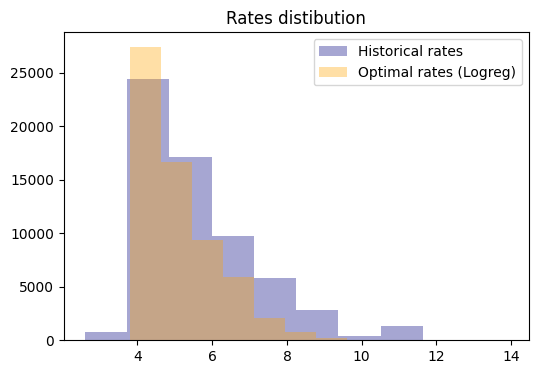

In [10]:
plot_rates_distribution(test_data, best_logreg_actions, method='Optimal rates (Logreg)')

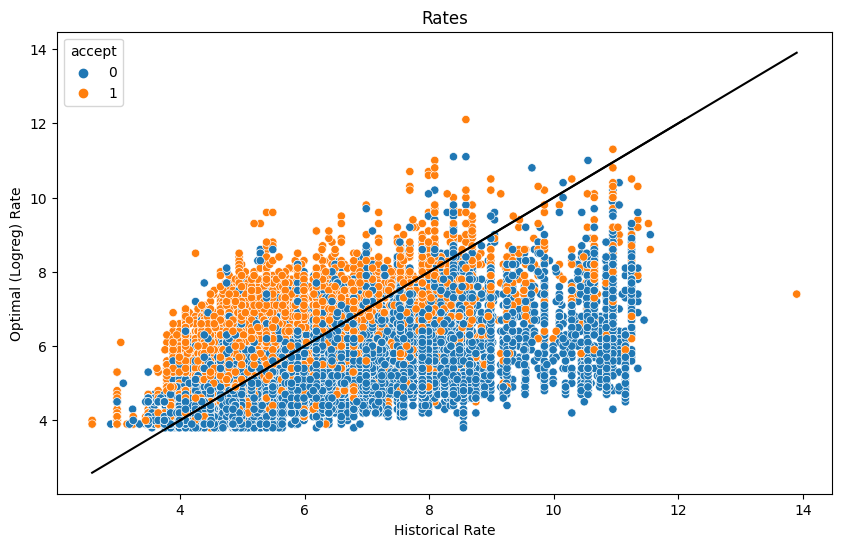

In [11]:
plot_rates(test_data, best_logreg_actions, method='Optimal (Logreg)')

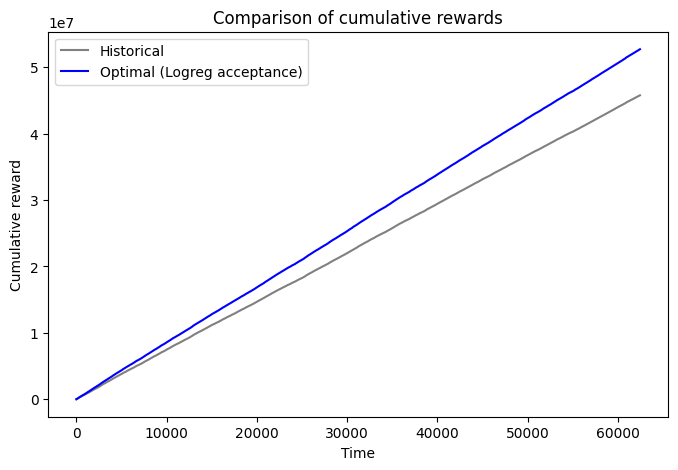

In [12]:
hist_reward_cumulative = np.cumsum(reward(test_data[state_columns], test_data['Rate'], 'logreg'))
opt_reward_cumulative = np.cumsum(reward(test_data[state_columns], best_logreg_actions, 'logreg'))
plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal (Logreg acceptance)')

LGBM acceptance:

In [13]:
best_lgbm_actions = greedy_search_best_action(test_data[state_columns].values, accept_model='lgbm')

best_lgbm_actions.min(), best_lgbm_actions.max(), best_lgbm_actions.mean()

0it [00:00, ?it/s]

(99.9, 99.9, 99.9)

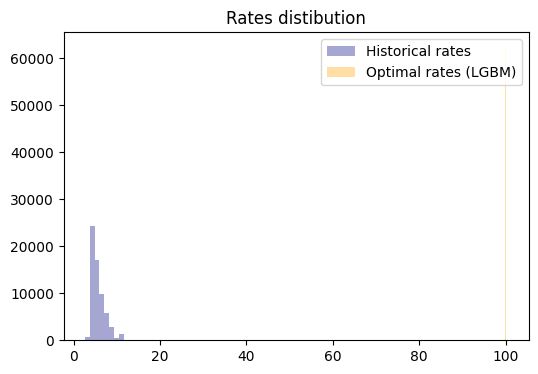

In [14]:
plot_rates_distribution(test_data, best_lgbm_actions, method='Optimal rates (LGBM)')

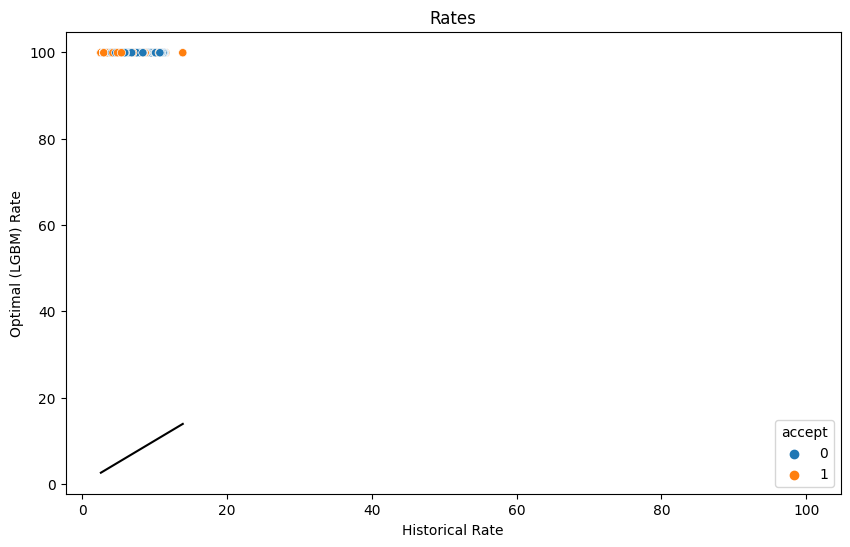

In [15]:
plot_rates(test_data, best_lgbm_actions, method='Optimal (LGBM)')

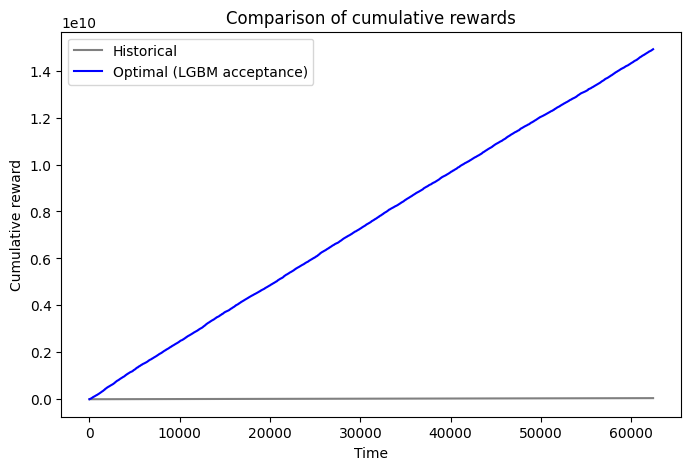

In [16]:
hist_reward_cumulative = np.cumsum(reward(test_data[state_columns], test_data['Rate'], 'lgbm'))
opt_reward_cumulative = np.cumsum(reward(test_data[state_columns], best_lgbm_actions, 'lgbm'))
plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal (LGBM acceptance)')

Random Forest acceptance:

In [17]:
best_rf_actions = greedy_search_best_action(test_data[state_columns].values, accept_model='rf')

best_rf_actions.min(), best_rf_actions.max(), best_rf_actions.mean()

0it [00:00, ?it/s]

(3.4, 99.9, 99.85572678050815)

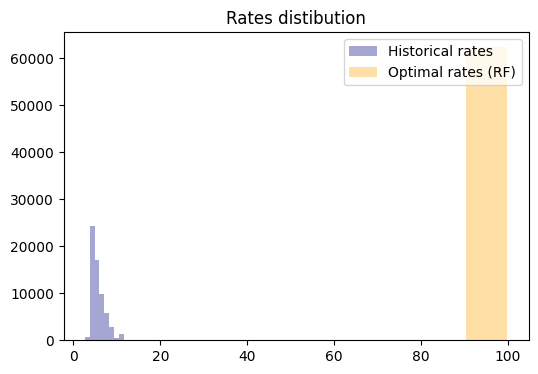

In [21]:
plot_rates_distribution(test_data, best_rf_actions, method='Optimal rates (RF)')

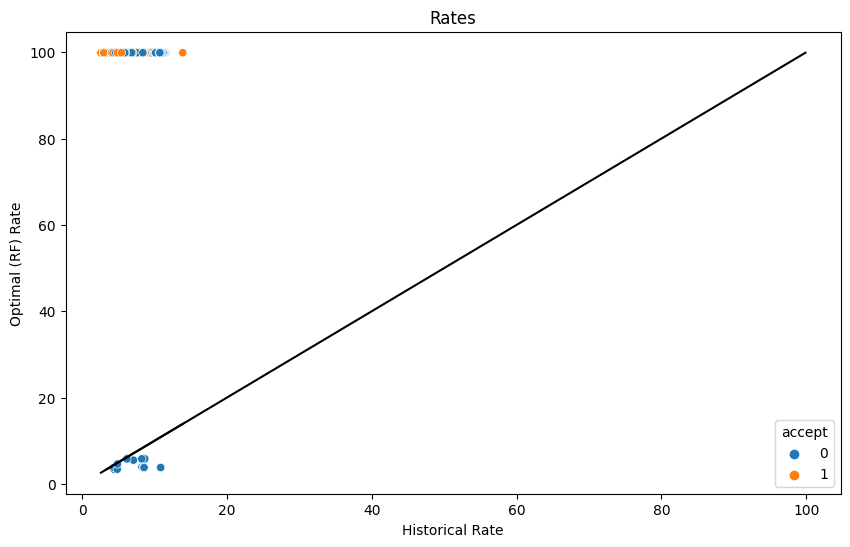

In [22]:
plot_rates(test_data, best_rf_actions, method='Optimal (RF)')

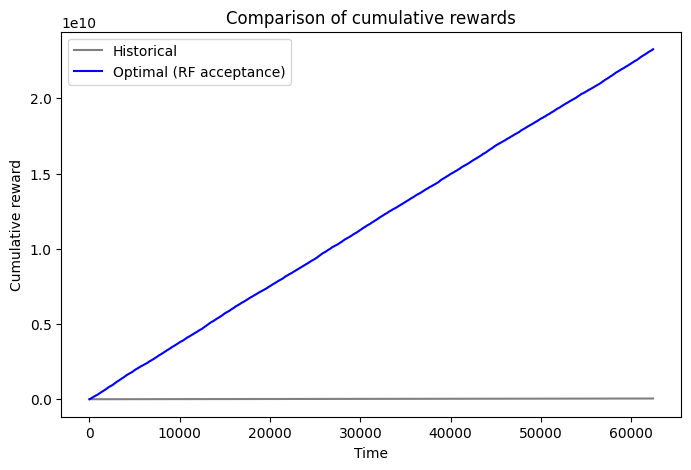

In [23]:
hist_reward_cumulative = np.cumsum(reward(test_data[state_columns], test_data['Rate'], 'rf'))
opt_reward_cumulative = np.cumsum(reward(test_data[state_columns], best_rf_actions, 'rf'))
plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal (RF acceptance)')

In [ ]:
# def gradient_decent_step(best_actions, states, lr=1e-15):
#     state_columns = [
#         'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
#         'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
#     ]
#     if states.shape == (len(state_columns), ):
#         states = states.reshape(1, -1)
#     X = pd.DataFrame(states, columns=state_columns)
    
#     p_accept = accept_proba(states, best_actions)
#     p_default = default_proba(states)
    
#     acceptance_model_name = 'acceptance_model'
#     acceptance_model = joblib.load(f'./{acceptance_model_name}.pkl')
#     rate_idx = np.argwhere(acceptance_model.steps[0][-1].get_feature_names_out() == 'scaling__Rate')[0][0]
#     rate_weight = acceptance_model.steps[-1][-1].coef_[:, rate_idx][0] 
    
#     loan_amount = X['Amount']
#     loan_term = X['Term'] / 12
#     rate = best_actions
#     prime_rate = 2 / 100
#     lgd = 0.5
#     total_payment = loan_amount * np.exp(rate / 100 * loan_term)
#     capital_cost = loan_amount * np.exp(prime_rate * loan_term)
    
#     rate_idx = np.argwhere(acceptance_model.steps[0][-1].get_feature_names_out() == 'scaling__Rate')[0][0]
#     rate_weight = acceptance_model.steps[-1][-1].coef_[:, rate_idx][0]    
    
#     reward_grad = (
#         rate_weight * p_accept * (1 - p_accept) * 
#         ((1 - p_default) * (total_payment - capital_cost) - p_default * lgd * capital_cost)
#         +
#         p_accept * (1 - p_default) * loan_term * total_payment
#     )
    
#     return best_actions - lr * reward_grad

# def reward_maximization(states, max_iter=10000, tolerance=1e-3, lr=1e-4):

#     best_actions = np.ones(shape=states.shape[0])
#     gradient_decent_step(best_actions, states, lr=1e-3)
    
#     for i in tqdm_notebook(range(max_iter)):
#         prev_actions = best_actions
#         best_actions = gradient_decent_step(best_actions, states, lr)

#         if (np.linalg.norm(best_actions - prev_actions, ord=2) ** 2) < tolerance:
#             print('Maximization interrupted by tolerance!')
#             print(f'Iter completed: {i}')
#             break
#         if sum(np.isnan(best_actions - prev_actions)) > 0:
#             print('Maximization interrupted by nans!')
#             print(f'Iter completed: {i}')
#             break
            
#     return best_actions

In [ ]:
def reward_for_optimize(rate, state):
    state_columns = [
        'Tier', 'FICO', 'Term', 'Amount', 'Previous_Rate', 'Competition_rate', 
        'Cost_Funds', 'Partner Bin', 'Car_Type_N', 'Car_Type_R', 'Car_Type_U'
    ]
    if state.shape == (len(state_columns), ):
        state = state.reshape(1, -1)
    X = pd.DataFrame(state, columns=state_columns)
    X['Rate'] = 0 # заглушка
    
    loan_amount = X['Amount']
    loan_term = X['Term'] / 12
    prime_rate = 2 / 100
    lgd = 0.5
    capital_cost = loan_amount * np.exp(prime_rate * loan_term)
    
    p_default = default_proba(state)
    
    acceptance_model = joblib.load('./acceptance_logreg_model.pkl')
    accept_transformer = acceptance_model.steps[0][-1]
    accept_model = acceptance_model.steps[-1][-1]
    
    rate_idx = np.argwhere(accept_transformer.get_feature_names_out() == 'pass__Rate')[0][0]
    X_trans = accept_transformer.transform(X)
    
    return ((
        1 /
        (1 + np.exp(
            - rate * accept_model.coef_[0][rate_idx]
            - X_trans[:, :rate_idx] @ accept_model.coef_[0][:rate_idx]
            - X_trans[:, rate_idx+1:] @ accept_model.coef_[0][rate_idx+1:]
            - accept_model.intercept_
        ))
    ) * (
        (1 - p_default) * (loan_amount * np.exp(rate / 100 * loan_term) - capital_cost) - 
        p_default * lgd * capital_cost
    )).values[0]

In [ ]:
states = X[state_columns].values
best_rates = [] 
for state in tqdm_notebook(states):
    best_rates.append(minimize_scalar(
        fun = lambda rate, args: -reward_for_optimize(rate, args), 
        args = (state),
        bounds = (0, 100), 
        method='bounded', 
    )['x'])
best_rates = np.array(best_rates) 

In [ ]:
# minimize(
#     fun = lambda rate, args: -reward_for_optimize(rate, args).mean(), 
#     x0 = np.zeros(X.shape[0]),
#     args = (X[state_columns]),
#     bounds = tuple([(0, 100)] * X.shape[0]), 
# #     method='bounded', 
# )

### DQN (d3rlpy):

In [24]:
observations = X.drop('Rate', axis=1).values
actions = (X['Rate'].round(1).values.reshape(-1,1) * 10).astype(np.int16)
rewards = reward(X.drop('Rate', axis=1).values, X['Rate'].round(1).values)
terminals = np.random.randint(2, size=observations.shape[0])

dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals
)

train_episodes, eval_episodes = train_test_split(dataset.episodes)

In [25]:
dqn = DQN(
    batch_size = 256,
    target_update_interval = 3000,
    use_gpu = False
)

dqn

d3rlpy.algos.dqn.DQN(action_scaler=None, batch_size=256, encoder_factory=d3rlpy.models.encoders.DefaultEncoderFactory(activation='relu', use_batch_norm=False, dropout_rate=None), gamma=0.99, generated_maxlen=100000, impl=None, learning_rate=6.25e-05, n_critics=1, n_frames=1, n_steps=1, optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), q_func_factory=d3rlpy.models.q_functions.MeanQFunctionFactory(share_encoder=False), real_ratio=1.0, reward_scaler=None, scaler=None, target_update_interval=3000, use_gpu=None)

In [26]:
dqn.fit(
    dataset=train_episodes,
    eval_episodes=eval_episodes,
    n_epochs=50,
    save_interval=5,
#     scorers={'td_error': d3rlpy.metrics.td_error_scorer}
)

2023-04-24 23:23.29 [debug    ] RoundIterator is selected.
2023-04-24 23:23.29 [info     ] Directory is created at d3rlpy_logs/DQN_20230424232329
2023-04-24 23:23.29 [debug    ] Building models...
2023-04-24 23:23.29 [debug    ] Models have been built.
2023-04-24 23:23.29 [info     ] Parameters are saved to d3rlpy_logs/DQN_20230424232329/params.json params={'action_scaler': None, 'batch_size': 256, 'encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 3000, 'use_gpu': None, 'algorithm': 'DQN', 'observation_shape': (11,), 'action_size': 156}


Epoch 1/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.32 [info     ] DQN_20230424232329: epoch=1 step=426 epoch=1 metrics={'time_sample_batch': 0.0003187208668167043, 'time_algorithm_update': 0.006299484503660963, 'loss': 717.2907825165511, 'time_step': 0.006670912106831868} step=426


Epoch 2/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.35 [info     ] DQN_20230424232329: epoch=2 step=852 epoch=2 metrics={'time_sample_batch': 0.00031671557627933124, 'time_algorithm_update': 0.006571325897610803, 'loss': 579.4013105222317, 'time_step': 0.006943595801160929} step=852


Epoch 3/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.37 [info     ] DQN_20230424232329: epoch=3 step=1278 epoch=3 metrics={'time_sample_batch': 0.000307535901315895, 'time_algorithm_update': 0.005646307703474878, 'loss': 517.2176257925973, 'time_step': 0.006000365449788984} step=1278


Epoch 4/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.40 [info     ] DQN_20230424232329: epoch=4 step=1704 epoch=4 metrics={'time_sample_batch': 0.00031499067942301434, 'time_algorithm_update': 0.005831150941445794, 'loss': 505.7970764446706, 'time_step': 0.006197158719452334} step=1704


Epoch 5/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.43 [info     ] DQN_20230424232329: epoch=5 step=2130 epoch=5 metrics={'time_sample_batch': 0.0003149487043210598, 'time_algorithm_update': 0.0058532539107989815, 'loss': 501.462505000298, 'time_step': 0.0062156053775912715} step=2130
2023-04-24 23:23.43 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_2130.pt


Epoch 6/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.45 [info     ] DQN_20230424232329: epoch=6 step=2556 epoch=6 metrics={'time_sample_batch': 0.0003064473470052083, 'time_algorithm_update': 0.00580229445802214, 'loss': 499.3639006995259, 'time_step': 0.006156618046648625} step=2556


Epoch 7/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.48 [info     ] DQN_20230424232329: epoch=7 step=2982 epoch=7 metrics={'time_sample_batch': 0.0003064842850949283, 'time_algorithm_update': 0.005383343763754401, 'loss': 498.070879152683, 'time_step': 0.00573844249259698} step=2982


Epoch 8/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.51 [info     ] DQN_20230424232329: epoch=8 step=3408 epoch=8 metrics={'time_sample_batch': 0.00030626209688858246, 'time_algorithm_update': 0.006531679014644712, 'loss': 838.8768364275005, 'time_step': 0.0068890690243859805} step=3408


Epoch 9/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.53 [info     ] DQN_20230424232329: epoch=9 step=3834 epoch=9 metrics={'time_sample_batch': 0.0003132780952632707, 'time_algorithm_update': 0.00537538360541975, 'loss': 793.6408188510949, 'time_step': 0.0057333982046781015} step=3834


Epoch 10/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.56 [info     ] DQN_20230424232329: epoch=10 step=4260 epoch=10 metrics={'time_sample_batch': 0.0003091320745262182, 'time_algorithm_update': 0.005507482609278719, 'loss': 786.3956983682696, 'time_step': 0.005864711994296508} step=4260
2023-04-24 23:23.56 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_4260.pt


Epoch 11/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:23.58 [info     ] DQN_20230424232329: epoch=11 step=4686 epoch=11 metrics={'time_sample_batch': 0.0003091164038214885, 'time_algorithm_update': 0.005528688430786133, 'loss': 783.5622783535523, 'time_step': 0.005886864774104016} step=4686


Epoch 12/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.01 [info     ] DQN_20230424232329: epoch=12 step=5112 epoch=12 metrics={'time_sample_batch': 0.0003031956757737997, 'time_algorithm_update': 0.005577002332803789, 'loss': 781.9589131673177, 'time_step': 0.005926385731764243} step=5112


Epoch 13/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.04 [info     ] DQN_20230424232329: epoch=13 step=5538 epoch=13 metrics={'time_sample_batch': 0.0003085410650906988, 'time_algorithm_update': 0.006210328827441578, 'loss': 780.6978964648896, 'time_step': 0.006565156676959544} step=5538


Epoch 14/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.07 [info     ] DQN_20230424232329: epoch=14 step=5964 epoch=14 metrics={'time_sample_batch': 0.0003182832064203253, 'time_algorithm_update': 0.006389436587481432, 'loss': 779.7418370493141, 'time_step': 0.006758155397406206} step=5964


Epoch 15/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.10 [info     ] DQN_20230424232329: epoch=15 step=6390 epoch=15 metrics={'time_sample_batch': 0.0003196426400556251, 'time_algorithm_update': 0.006557660483418496, 'loss': 1248.5194871212955, 'time_step': 0.006925717206068442} step=6390
2023-04-24 23:24.10 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_6390.pt


Epoch 16/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.12 [info     ] DQN_20230424232329: epoch=16 step=6816 epoch=16 metrics={'time_sample_batch': 0.0003105939274102869, 'time_algorithm_update': 0.0059998337651642275, 'loss': 1260.854815415933, 'time_step': 0.006351859916543736} step=6816


Epoch 17/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.15 [info     ] DQN_20230424232329: epoch=17 step=7242 epoch=17 metrics={'time_sample_batch': 0.0003028190191922613, 'time_algorithm_update': 0.006201943881075147, 'loss': 1256.8652252053992, 'time_step': 0.006543291566517432} step=7242


Epoch 18/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.18 [info     ] DQN_20230424232329: epoch=18 step=7668 epoch=18 metrics={'time_sample_batch': 0.000310202719460071, 'time_algorithm_update': 0.007002095661252877, 'loss': 1255.7409685161751, 'time_step': 0.007353053406370638} step=7668


Epoch 19/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.21 [info     ] DQN_20230424232329: epoch=19 step=8094 epoch=19 metrics={'time_sample_batch': 0.00030697567362180896, 'time_algorithm_update': 0.0066589111453490635, 'loss': 1255.0903755868544, 'time_step': 0.007009604167490498} step=8094


Epoch 20/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.24 [info     ] DQN_20230424232329: epoch=20 step=8520 epoch=20 metrics={'time_sample_batch': 0.00030878228200993067, 'time_algorithm_update': 0.005696990680246846, 'loss': 1254.4742795559162, 'time_step': 0.006045681210191037} step=8520
2023-04-24 23:24.24 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_8520.pt


Epoch 21/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.26 [info     ] DQN_20230424232329: epoch=21 step=8946 epoch=21 metrics={'time_sample_batch': 0.0003062839239415988, 'time_algorithm_update': 0.005723596738537712, 'loss': 1253.9835397066645, 'time_step': 0.006073026589944329} step=8946


Epoch 22/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.29 [info     ] DQN_20230424232329: epoch=22 step=9372 epoch=22 metrics={'time_sample_batch': 0.00031016802004245526, 'time_algorithm_update': 0.0062123195666102735, 'loss': 1540.0203014964789, 'time_step': 0.006566841837386011} step=9372


Epoch 23/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.32 [info     ] DQN_20230424232329: epoch=23 step=9798 epoch=23 metrics={'time_sample_batch': 0.00030097939039060205, 'time_algorithm_update': 0.006592474073311532, 'loss': 1573.5390782602517, 'time_step': 0.006930708885192871} step=9798


Epoch 24/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.35 [info     ] DQN_20230424232329: epoch=24 step=10224 epoch=24 metrics={'time_sample_batch': 0.00030746706214868964, 'time_algorithm_update': 0.005577969998820847, 'loss': 1572.0409875430971, 'time_step': 0.005925924005642743} step=10224


Epoch 25/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.37 [info     ] DQN_20230424232329: epoch=25 step=10650 epoch=25 metrics={'time_sample_batch': 0.00030215917058953656, 'time_algorithm_update': 0.005303485852451951, 'loss': 1571.4395187449568, 'time_step': 0.005642603260810387} step=10650
2023-04-24 23:24.37 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_10650.pt


Epoch 26/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.40 [info     ] DQN_20230424232329: epoch=26 step=11076 epoch=26 metrics={'time_sample_batch': 0.00030668912359246625, 'time_algorithm_update': 0.0053796734608395, 'loss': 1570.9111164791484, 'time_step': 0.0057277231708938526} step=11076


Epoch 27/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.42 [info     ] DQN_20230424232329: epoch=27 step=11502 epoch=27 metrics={'time_sample_batch': 0.0003055143804057663, 'time_algorithm_update': 0.005646989379130619, 'loss': 1570.7337176542326, 'time_step': 0.005992864219235702} step=11502


Epoch 28/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.45 [info     ] DQN_20230424232329: epoch=28 step=11928 epoch=28 metrics={'time_sample_batch': 0.0002964869351454184, 'time_algorithm_update': 0.005182715648776488, 'loss': 1570.2856322095988, 'time_step': 0.0055181403674989795} step=11928


Epoch 29/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.47 [info     ] DQN_20230424232329: epoch=29 step=12354 epoch=29 metrics={'time_sample_batch': 0.00030233154834156305, 'time_algorithm_update': 0.006016510753004764, 'loss': 1713.3995653609154, 'time_step': 0.006360929896574065} step=12354


Epoch 30/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.50 [info     ] DQN_20230424232329: epoch=30 step=12780 epoch=30 metrics={'time_sample_batch': 0.00029996807026751166, 'time_algorithm_update': 0.005340805635765685, 'loss': 1739.6221402307071, 'time_step': 0.005682055379303408} step=12780
2023-04-24 23:24.50 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_12780.pt


Epoch 31/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.52 [info     ] DQN_20230424232329: epoch=31 step=13206 epoch=31 metrics={'time_sample_batch': 0.0003020847347420706, 'time_algorithm_update': 0.00554430708638939, 'loss': 1739.1400668005429, 'time_step': 0.0058841302361286865} step=13206


Epoch 32/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.55 [info     ] DQN_20230424232329: epoch=32 step=13632 epoch=32 metrics={'time_sample_batch': 0.00030591902038860767, 'time_algorithm_update': 0.005539459241947657, 'loss': 1738.7206180196413, 'time_step': 0.005888858871280867} step=13632


Epoch 33/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:24.57 [info     ] DQN_20230424232329: epoch=33 step=14058 epoch=33 metrics={'time_sample_batch': 0.0003047448368699338, 'time_algorithm_update': 0.00537230822961655, 'loss': 1738.408097388039, 'time_step': 0.005716454255189135} step=14058


Epoch 34/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.00 [info     ] DQN_20230424232329: epoch=34 step=14484 epoch=34 metrics={'time_sample_batch': 0.00031195951739387335, 'time_algorithm_update': 0.006552144955021675, 'loss': 1738.1756571738374, 'time_step': 0.006909623951979087} step=14484


Epoch 35/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.03 [info     ] DQN_20230424232329: epoch=35 step=14910 epoch=35 metrics={'time_sample_batch': 0.00030595595847832764, 'time_algorithm_update': 0.005973598207106612, 'loss': 1737.8340316557549, 'time_step': 0.006320680251143908} step=14910
2023-04-24 23:25.03 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_14910.pt


Epoch 36/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.06 [info     ] DQN_20230424232329: epoch=36 step=15336 epoch=36 metrics={'time_sample_batch': 0.00030382866031127356, 'time_algorithm_update': 0.005850723091985139, 'loss': 1858.8992077464789, 'time_step': 0.0061966231171513945} step=15336


Epoch 37/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.08 [info     ] DQN_20230424232329: epoch=37 step=15762 epoch=37 metrics={'time_sample_batch': 0.00030841066244062683, 'time_algorithm_update': 0.005388249254002817, 'loss': 1889.1163928967687, 'time_step': 0.005736438321395659} step=15762


Epoch 38/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.11 [info     ] DQN_20230424232329: epoch=38 step=16188 epoch=38 metrics={'time_sample_batch': 0.00030539740978831976, 'time_algorithm_update': 0.0055127776284732725, 'loss': 1888.6049045329921, 'time_step': 0.005858654707250461} step=16188


Epoch 39/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.13 [info     ] DQN_20230424232329: epoch=39 step=16614 epoch=39 metrics={'time_sample_batch': 0.0003041118523324599, 'time_algorithm_update': 0.005182519205299342, 'loss': 1888.4270947953346, 'time_step': 0.005527772254227473} step=16614


Epoch 40/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.16 [info     ] DQN_20230424232329: epoch=40 step=17040 epoch=40 metrics={'time_sample_batch': 0.0003019084393138617, 'time_algorithm_update': 0.006024462516319024, 'loss': 1887.9536213046508, 'time_step': 0.006366794657819148} step=17040
2023-04-24 23:25.16 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_17040.pt


Epoch 41/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.18 [info     ] DQN_20230424232329: epoch=41 step=17466 epoch=41 metrics={'time_sample_batch': 0.000313570241972874, 'time_algorithm_update': 0.005580547829748879, 'loss': 1887.5516366018376, 'time_step': 0.005938860172397094} step=17466


Epoch 42/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.21 [info     ] DQN_20230424232329: epoch=42 step=17892 epoch=42 metrics={'time_sample_batch': 0.0002994296696264419, 'time_algorithm_update': 0.005051182469291866, 'loss': 1887.4110239234888, 'time_step': 0.005389701592530443} step=17892


Epoch 43/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.23 [info     ] DQN_20230424232329: epoch=43 step=18318 epoch=43 metrics={'time_sample_batch': 0.00031297363585709406, 'time_algorithm_update': 0.005537495366844213, 'loss': 2008.5414821284478, 'time_step': 0.005894631846969676} step=18318


Epoch 44/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.26 [info     ] DQN_20230424232329: epoch=44 step=18744 epoch=44 metrics={'time_sample_batch': 0.0003107802968629649, 'time_algorithm_update': 0.005070653319918494, 'loss': 2048.6849305058868, 'time_step': 0.005423454611514096} step=18744


Epoch 45/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.28 [info     ] DQN_20230424232329: epoch=45 step=19170 epoch=45 metrics={'time_sample_batch': 0.00029692851321797974, 'time_algorithm_update': 0.005244255065917969, 'loss': 2048.3395506093198, 'time_step': 0.005579993198735054} step=19170
2023-04-24 23:25.28 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_19170.pt


Epoch 46/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.30 [info     ] DQN_20230424232329: epoch=46 step=19596 epoch=46 metrics={'time_sample_batch': 0.0003075224692832696, 'time_algorithm_update': 0.0053286367738750616, 'loss': 2047.9013156084948, 'time_step': 0.005675951639811198} step=19596


Epoch 47/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.33 [info     ] DQN_20230424232329: epoch=47 step=20022 epoch=47 metrics={'time_sample_batch': 0.0003087285538794289, 'time_algorithm_update': 0.005246146743846052, 'loss': 2047.4824250270503, 'time_step': 0.005597612107863448} step=20022


Epoch 48/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.35 [info     ] DQN_20230424232329: epoch=48 step=20448 epoch=48 metrics={'time_sample_batch': 0.0003006385525627315, 'time_algorithm_update': 0.00495570870072629, 'loss': 2047.260509508876, 'time_step': 0.00529969186290329} step=20448


Epoch 49/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.37 [info     ] DQN_20230424232329: epoch=49 step=20874 epoch=49 metrics={'time_sample_batch': 0.00030250112775345923, 'time_algorithm_update': 0.005010411213261421, 'loss': 2046.9800607027582, 'time_step': 0.0053540708873193585} step=20874


Epoch 50/50:   0%|          | 0/426 [00:00<?, ?it/s]

2023-04-24 23:25.40 [info     ] DQN_20230424232329: epoch=50 step=21300 epoch=50 metrics={'time_sample_batch': 0.00031207424933921564, 'time_algorithm_update': 0.005225686959817376, 'loss': 2145.102206091366, 'time_step': 0.005579711126049919} step=21300
2023-04-24 23:25.40 [info     ] Model parameters are saved to d3rlpy_logs/DQN_20230424232329/model_21300.pt


[(1,
  {'time_sample_batch': 0.0003187208668167043,
   'time_algorithm_update': 0.006299484503660963,
   'loss': 717.2907825165511,
   'time_step': 0.006670912106831868}),
 (2,
  {'time_sample_batch': 0.00031671557627933124,
   'time_algorithm_update': 0.006571325897610803,
   'loss': 579.4013105222317,
   'time_step': 0.006943595801160929}),
 (3,
  {'time_sample_batch': 0.000307535901315895,
   'time_algorithm_update': 0.005646307703474878,
   'loss': 517.2176257925973,
   'time_step': 0.006000365449788984}),
 (4,
  {'time_sample_batch': 0.00031499067942301434,
   'time_algorithm_update': 0.005831150941445794,
   'loss': 505.7970764446706,
   'time_step': 0.006197158719452334}),
 (5,
  {'time_sample_batch': 0.0003149487043210598,
   'time_algorithm_update': 0.0058532539107989815,
   'loss': 501.462505000298,
   'time_step': 0.0062156053775912715}),
 (6,
  {'time_sample_batch': 0.0003064473470052083,
   'time_algorithm_update': 0.00580229445802214,
   'loss': 499.3639006995259,
   'tim

In [31]:
best_dqn_actions = dqn.predict(test_data[state_columns].values) / 10

best_dqn_actions.min(), best_dqn_actions.max(), best_dqn_actions.mean()

(11.4, 11.4, 11.400000000000004)

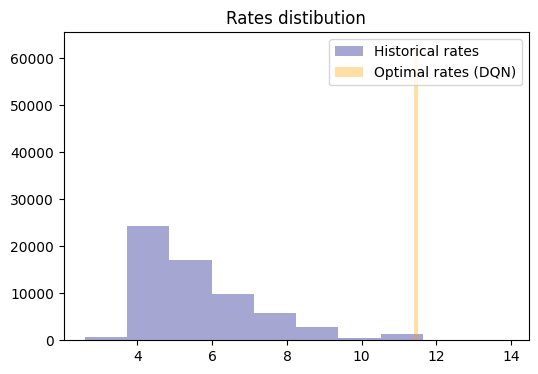

In [32]:
plot_rates_distribution(test_data, best_dqn_actions, method='Optimal rates (DQN)')

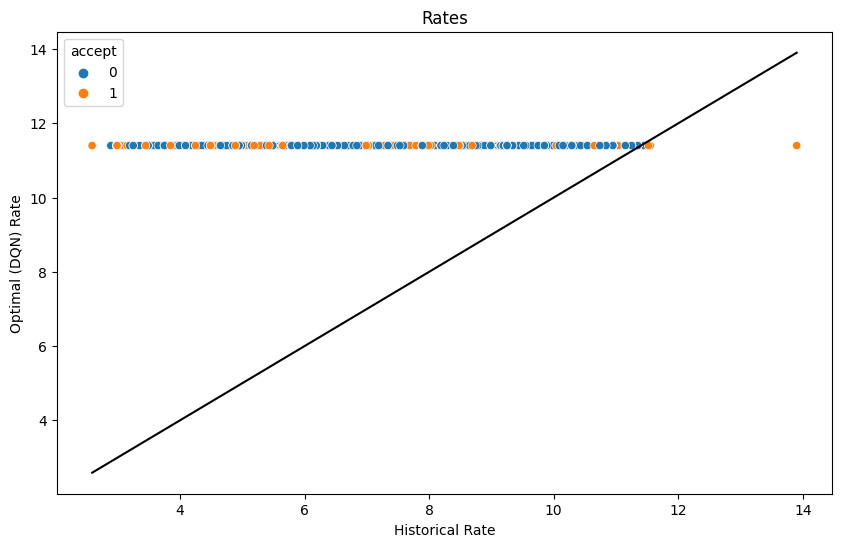

In [33]:
plot_rates(test_data, best_dqn_actions, method='Optimal (DQN)')

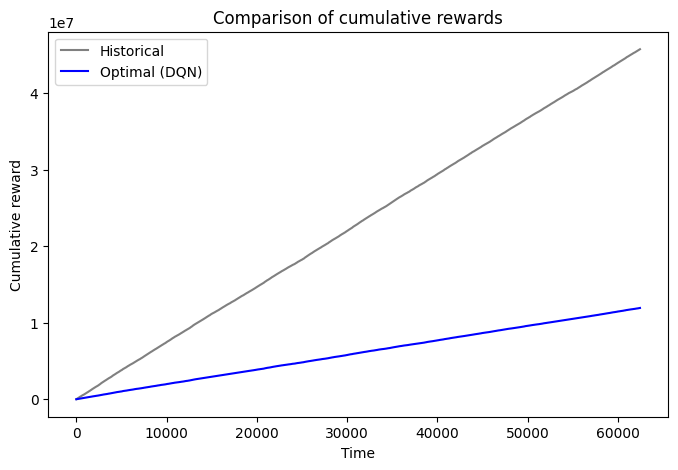

In [34]:
hist_reward_cumulative = np.cumsum(reward(test_data[state_columns], test_data['Rate'], 'logreg'))
opt_reward_cumulative = np.cumsum(reward(test_data[state_columns], best_dqn_actions, 'logreg'))
plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal (DQN)')

### CQL (d3rlpy):

In [35]:
observations = X.drop('Rate', axis=1).values
actions = X['Rate'].values.reshape(-1,1)
rewards = reward(X.drop('Rate', axis=1).values, X['Rate'].values)
terminals = np.random.randint(2, size=observations.shape[0])

dataset = MDPDataset(
    observations=observations,
    actions=actions,
    rewards=rewards,
    terminals=terminals
)

train_episodes, eval_episodes = train_test_split(dataset.episodes)

In [63]:
cql = CQL(
    batch_size = 512,
    use_gpu = False 
)

cql

d3rlpy.algos.cql.CQL(action_scaler=None, actor_encoder_factory=d3rlpy.models.encoders.DefaultEncoderFactory(activation='relu', use_batch_norm=False, dropout_rate=None), actor_learning_rate=0.0001, actor_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), alpha_learning_rate=0.0001, alpha_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), alpha_threshold=10.0, batch_size=512, conservative_weight=5.0, critic_encoder_factory=d3rlpy.models.encoders.DefaultEncoderFactory(activation='relu', use_batch_norm=False, dropout_rate=None), critic_learning_rate=0.0003, critic_optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), gamma=0.99, generated_maxlen=100000, impl=None, initial_alpha=1.0, initial_temperature=1.0, n_action_samples=10, n_critics=2, n_frames=1, n

In [64]:
cql.fit(
    dataset=train_episodes,
    eval_episodes=eval_episodes,
    n_epochs=100,
    save_interval=5,
#     scorers={'td_error': d3rlpy.metrics.td_error_scorer}
)

2023-04-25 00:01.16 [debug    ] RoundIterator is selected.
2023-04-25 00:01.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230425000116
2023-04-25 00:01.16 [debug    ] Building models...
2023-04-25 00:01.16 [debug    ] Models have been built.
2023-04-25 00:01.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230425000116/params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_threshold': 10.0, 'batch_size': 512, 'conservative_weight': 5.0, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rat

Epoch 1/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:02.01 [info     ] CQL_20230425000116: epoch=1 step=213 epoch=1 metrics={'time_sample_batch': 0.0006704050610322908, 'time_algorithm_update': 0.21097848896689259, 'temp_loss': 0.4601660110384331, 'temp': 0.9927035200763756, 'alpha_loss': 172.14440482141268, 'alpha': 0.9906966828964126, 'critic_loss': 2220034.0504694837, 'actor_loss': -100.34595937432258, 'time_step': 0.21173425235658744} step=213


Epoch 2/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:02.46 [info     ] CQL_20230425000116: epoch=2 step=426 epoch=2 metrics={'time_sample_batch': 0.000669306992365161, 'time_algorithm_update': 0.20839789104013937, 'temp_loss': -1.7208490701908237, 'temp': 1.0068130143371545, 'alpha_loss': 849.4944841984852, 'alpha': 0.9527639466831942, 'critic_loss': 1626956.465669014, 'actor_loss': -400.14255620392277, 'time_step': 0.20915164746029277} step=426


Epoch 3/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:03.30 [info     ] CQL_20230425000116: epoch=3 step=639 epoch=3 metrics={'time_sample_batch': 0.0006734608484545784, 'time_algorithm_update': 0.20746714744209682, 'temp_loss': -2.2421677974468106, 'temp': 1.0356141994816597, 'alpha_loss': 1283.6927553275382, 'alpha': 0.9201962847105214, 'critic_loss': 1543225.059859155, 'actor_loss': -518.8002976968255, 'time_step': 0.20822531964297586} step=639


Epoch 4/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:04.16 [info     ] CQL_20230425000116: epoch=4 step=852 epoch=4 metrics={'time_sample_batch': 0.0006731340023273594, 'time_algorithm_update': 0.21282568895760837, 'temp_loss': -2.5302272749618746, 'temp': 1.0645478762371439, 'alpha_loss': 1569.345742095804, 'alpha': 0.8917561330146073, 'critic_loss': 1549621.7846244131, 'actor_loss': -562.7905118700484, 'time_step': 0.21358169748189865} step=852


Epoch 5/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:05.02 [info     ] CQL_20230425000116: epoch=5 step=1065 epoch=5 metrics={'time_sample_batch': 0.0006708013059947412, 'time_algorithm_update': 0.21272836940389284, 'temp_loss': -2.6913086248675424, 'temp': 1.0930584053478332, 'alpha_loss': 1757.6668030644807, 'alpha': 0.8659248248512197, 'critic_loss': 1556159.4548122066, 'actor_loss': -571.7862752278646, 'time_step': 0.21348319814798417} step=1065
2023-04-25 00:05.02 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_1065.pt


Epoch 6/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:06.21 [info     ] CQL_20230425000116: epoch=6 step=1278 epoch=6 metrics={'time_sample_batch': 0.0007069289964129667, 'time_algorithm_update': 0.3733834929309541, 'temp_loss': -2.8692195997551573, 'temp': 1.121558426131665, 'alpha_loss': 1887.0970716879401, 'alpha': 0.8421805053249771, 'critic_loss': 1540337.5680751174, 'actor_loss': -524.7886825346611, 'time_step': 0.3741830760884173} step=1278


Epoch 7/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:10.22 [info     ] CQL_20230425000116: epoch=7 step=1491 epoch=7 metrics={'time_sample_batch': 0.0006835001735060427, 'time_algorithm_update': 1.1270484610902312, 'temp_loss': -3.000612497329712, 'temp': 1.1503848509049752, 'alpha_loss': 2001.4776399281104, 'alpha': 0.819768746414095, 'critic_loss': 1510183.890258216, 'actor_loss': -490.33095367861466, 'time_step': 1.1278169211087652} step=1491


Epoch 8/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:15.26 [info     ] CQL_20230425000116: epoch=8 step=1704 epoch=8 metrics={'time_sample_batch': 0.0007253252844295591, 'time_algorithm_update': 1.4267063711730528, 'temp_loss': -3.1301491238141845, 'temp': 1.1795083726515792, 'alpha_loss': 2103.401568918721, 'alpha': 0.7985806109759729, 'critic_loss': 1478201.4524647887, 'actor_loss': -433.67965583622174, 'time_step': 1.4275216362286063} step=1704


Epoch 9/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:20.32 [info     ] CQL_20230425000116: epoch=9 step=1917 epoch=9 metrics={'time_sample_batch': 0.0006802966337248752, 'time_algorithm_update': 1.4348829486560373, 'temp_loss': -3.3483665202145287, 'temp': 1.209444759597241, 'alpha_loss': 2205.4649652472126, 'alpha': 0.778291856459049, 'critic_loss': 1445681.7177230048, 'actor_loss': -372.5412455813985, 'time_step': 1.4356512967409663} step=1917


Epoch 10/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:24.43 [info     ] CQL_20230425000116: epoch=10 step=2130 epoch=10 metrics={'time_sample_batch': 0.0006776292559126733, 'time_algorithm_update': 1.1785917718645553, 'temp_loss': -3.3913966232622172, 'temp': 1.2398207719337213, 'alpha_loss': 2279.164100324604, 'alpha': 0.7588276233471615, 'critic_loss': 1415739.156983568, 'actor_loss': -309.3436434033891, 'time_step': 1.1793545367012561} step=2130
2023-04-25 00:24.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_2130.pt


Epoch 11/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:25.28 [info     ] CQL_20230425000116: epoch=11 step=2343 epoch=11 metrics={'time_sample_batch': 0.0006754398345947266, 'time_algorithm_update': 0.20974376839651188, 'temp_loss': -3.534673835190249, 'temp': 1.270542901446562, 'alpha_loss': 2371.22128997946, 'alpha': 0.7401121323097479, 'critic_loss': 1387816.1076877934, 'actor_loss': -239.28960099914264, 'time_step': 0.2105102449515616} step=2343


Epoch 12/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:26.14 [info     ] CQL_20230425000116: epoch=12 step=2556 epoch=12 metrics={'time_sample_batch': 0.0006786086749582783, 'time_algorithm_update': 0.21321645924742794, 'temp_loss': -3.662314558253042, 'temp': 1.3019871252803175, 'alpha_loss': 2451.3145333590082, 'alpha': 0.7219624337456036, 'critic_loss': 1364628.7699530516, 'actor_loss': -168.94690994477608, 'time_step': 0.21398051355926084} step=2556


Epoch 13/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:27.00 [info     ] CQL_20230425000116: epoch=13 step=2769 epoch=13 metrics={'time_sample_batch': 0.00067730017111335, 'time_algorithm_update': 0.21413328166299023, 'temp_loss': -3.8402475963735805, 'temp': 1.3343122033446049, 'alpha_loss': 2547.50917762434, 'alpha': 0.704355947288549, 'critic_loss': 1344805.2098004695, 'actor_loss': -90.39988090622593, 'time_step': 0.21489538385274826} step=2769


Epoch 14/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:27.46 [info     ] CQL_20230425000116: epoch=14 step=2982 epoch=14 metrics={'time_sample_batch': 0.0006747469655784642, 'time_algorithm_update': 0.21535251621908985, 'temp_loss': -3.9210120277225693, 'temp': 1.3673092636144217, 'alpha_loss': 2611.0840955564113, 'alpha': 0.6873346897358066, 'critic_loss': 1330057.6156103287, 'actor_loss': -14.541563249249974, 'time_step': 0.2161198770496207} step=2982


Epoch 15/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:31.48 [info     ] CQL_20230425000116: epoch=15 step=3195 epoch=15 metrics={'time_sample_batch': 0.0006796574928391147, 'time_algorithm_update': 1.137522454552807, 'temp_loss': -4.05754606152924, 'temp': 1.4009243848737976, 'alpha_loss': 2693.1874449823945, 'alpha': 0.6708170903120803, 'critic_loss': 1323183.0642605633, 'actor_loss': 69.39189480168159, 'time_step': 1.138288289728299} step=3195
2023-04-25 00:31.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_3195.pt


Epoch 16/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:36.53 [info     ] CQL_20230425000116: epoch=16 step=3408 epoch=16 metrics={'time_sample_batch': 0.0006860242763035734, 'time_algorithm_update': 1.4273197885969995, 'temp_loss': -4.177024098069455, 'temp': 1.4352596444143375, 'alpha_loss': 2805.9365864785063, 'alpha': 0.6546771993659471, 'critic_loss': 1325386.205399061, 'actor_loss': 165.35322646020163, 'time_step': 1.4280908667425594} step=3408


Epoch 17/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:41.06 [info     ] CQL_20230425000116: epoch=17 step=3621 epoch=17 metrics={'time_sample_batch': 0.0006791437175911917, 'time_algorithm_update': 1.1887689207641172, 'temp_loss': -4.15393541900205, 'temp': 1.4698887352652392, 'alpha_loss': 2801.8709057731808, 'alpha': 0.6391312102196922, 'critic_loss': 1331374.5017605633, 'actor_loss': 228.45681812841568, 'time_step': 1.189538103873741} step=3621


Epoch 18/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:46.14 [info     ] CQL_20230425000116: epoch=18 step=3834 epoch=18 metrics={'time_sample_batch': 0.0006790463353546572, 'time_algorithm_update': 1.4437424095583633, 'temp_loss': -4.079051859501941, 'temp': 1.5041425149765373, 'alpha_loss': 2837.53261856294, 'alpha': 0.6242138357229636, 'critic_loss': 1345006.2901995305, 'actor_loss': 297.0824851452465, 'time_step': 1.4445131015329853} step=3834


Epoch 19/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:51.51 [info     ] CQL_20230425000116: epoch=19 step=4047 epoch=19 metrics={'time_sample_batch': 0.0006933592854531158, 'time_algorithm_update': 1.430052358779549, 'temp_loss': -3.874613498857883, 'temp': 1.537350508528696, 'alpha_loss': 2826.9448677743544, 'alpha': 0.6099718753161005, 'critic_loss': 1358702.8403755869, 'actor_loss': 349.8041979292749, 'time_step': 1.4308377756199366} step=4047


Epoch 20/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 00:56.55 [info     ] CQL_20230425000116: epoch=20 step=4260 epoch=20 metrics={'time_sample_batch': 0.0007006551178408341, 'time_algorithm_update': 1.4277604129952444, 'temp_loss': -3.819750321303175, 'temp': 1.5702281126953626, 'alpha_loss': 2810.570429412412, 'alpha': 0.5962848184813916, 'critic_loss': 1374884.9395539905, 'actor_loss': 391.01672406263754, 'time_step': 1.428547614057299} step=4260
2023-04-25 00:56.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_4260.pt


Epoch 21/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:01.27 [info     ] CQL_20230425000116: epoch=21 step=4473 epoch=21 metrics={'time_sample_batch': 0.0006830681097899244, 'time_algorithm_update': 1.2730844860345545, 'temp_loss': -3.740855060272933, 'temp': 1.6032938766927227, 'alpha_loss': 2767.4553887452316, 'alpha': 0.5832465391763499, 'critic_loss': 1386274.0058685446, 'actor_loss': 420.97098652297905, 'time_step': 1.2738611116095888} step=4473


Epoch 22/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:05.25 [info     ] CQL_20230425000116: epoch=22 step=4686 epoch=22 metrics={'time_sample_batch': 0.0006881151960489336, 'time_algorithm_update': 1.1196665618341293, 'temp_loss': -3.994709593589317, 'temp': 1.6383368470859079, 'alpha_loss': 2746.0726782570423, 'alpha': 0.5706862980770953, 'critic_loss': 1400541.0469483568, 'actor_loss': 451.74492921068077, 'time_step': 1.1204400051367676} step=4686


Epoch 23/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:06.12 [info     ] CQL_20230425000116: epoch=23 step=4899 epoch=23 metrics={'time_sample_batch': 0.0006746585380303468, 'time_algorithm_update': 0.2157405183908525, 'temp_loss': -3.7121452871062948, 'temp': 1.6728542433098448, 'alpha_loss': 2702.1279445881014, 'alpha': 0.5586094151080494, 'critic_loss': 1408559.815140845, 'actor_loss': 472.9355196527472, 'time_step': 0.21650013229656667} step=4899


Epoch 24/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:06.57 [info     ] CQL_20230425000116: epoch=24 step=5112 epoch=24 metrics={'time_sample_batch': 0.0006757286232961736, 'time_algorithm_update': 0.21373673895714987, 'temp_loss': -3.6878218326210415, 'temp': 1.7074997699316679, 'alpha_loss': 2693.3587663677376, 'alpha': 0.5468541162674416, 'critic_loss': 1421617.66842723, 'actor_loss': 505.37119447233533, 'time_step': 0.21449929335867296} step=5112


Epoch 25/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:07.45 [info     ] CQL_20230425000116: epoch=25 step=5325 epoch=25 metrics={'time_sample_batch': 0.0007140546897207627, 'time_algorithm_update': 0.2204171379966915, 'temp_loss': -3.708758626185672, 'temp': 1.7430011716806832, 'alpha_loss': 2621.704139387104, 'alpha': 0.5355139052923856, 'critic_loss': 1429664.204225352, 'actor_loss': 510.7759072747029, 'time_step': 0.2212224868541592} step=5325
2023-04-25 01:07.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_5325.pt


Epoch 26/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:08.30 [info     ] CQL_20230425000116: epoch=26 step=5538 epoch=26 metrics={'time_sample_batch': 0.0006725508282442048, 'time_algorithm_update': 0.21291924530351666, 'temp_loss': -3.711204300464039, 'temp': 1.779369077212374, 'alpha_loss': 2609.7012842026115, 'alpha': 0.5245334603976756, 'critic_loss': 1435720.8274647887, 'actor_loss': 535.7532480445826, 'time_step': 0.21368035464219645} step=5538


Epoch 27/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:09.20 [info     ] CQL_20230425000116: epoch=27 step=5751 epoch=27 metrics={'time_sample_batch': 0.0007270266752287815, 'time_algorithm_update': 0.2321821971678398, 'temp_loss': -3.6375433178574825, 'temp': 1.8168547108699458, 'alpha_loss': 2562.2888195055752, 'alpha': 0.5138426803647073, 'critic_loss': 1443647.9354460095, 'actor_loss': 552.9115594854937, 'time_step': 0.23300649974267806} step=5751


Epoch 28/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:10.10 [info     ] CQL_20230425000116: epoch=28 step=5964 epoch=28 metrics={'time_sample_batch': 0.0007415422251526738, 'time_algorithm_update': 0.23191155402313376, 'temp_loss': -3.6010990814423898, 'temp': 1.8544647022032401, 'alpha_loss': 2543.317724380135, 'alpha': 0.5034015237445563, 'critic_loss': 1454676.5974178403, 'actor_loss': 575.871221551313, 'time_step': 0.23275171982850268} step=5964


Epoch 29/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:11.00 [info     ] CQL_20230425000116: epoch=29 step=6177 epoch=29 metrics={'time_sample_batch': 0.0007437383624869333, 'time_algorithm_update': 0.2343782236878301, 'temp_loss': -3.625954222791072, 'temp': 1.893182251375046, 'alpha_loss': 2505.1458127017313, 'alpha': 0.49321599059821297, 'critic_loss': 1462747.7147887324, 'actor_loss': 591.9518320862676, 'time_step': 0.23521867940123653} step=6177


Epoch 30/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:11.52 [info     ] CQL_20230425000116: epoch=30 step=6390 epoch=30 metrics={'time_sample_batch': 0.0007254954235094813, 'time_algorithm_update': 0.2442246916148584, 'temp_loss': -3.625141829951828, 'temp': 1.9328517314973572, 'alpha_loss': 2494.806953537632, 'alpha': 0.48325778508969874, 'critic_loss': 1473715.8259976525, 'actor_loss': 622.3129816905994, 'time_step': 0.2450458936288323} step=6390
2023-04-25 01:11.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_6390.pt


Epoch 31/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:12.46 [info     ] CQL_20230425000116: epoch=31 step=6603 epoch=31 metrics={'time_sample_batch': 0.0007323513568287164, 'time_algorithm_update': 0.2506508681695786, 'temp_loss': -3.7014603536453605, 'temp': 1.9740713431801595, 'alpha_loss': 2450.9806716274206, 'alpha': 0.4735218811203057, 'critic_loss': 1483531.7523474179, 'actor_loss': 634.6610826662449, 'time_step': 0.25148404707931016} step=6603


Epoch 32/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:13.39 [info     ] CQL_20230425000116: epoch=32 step=6816 epoch=32 metrics={'time_sample_batch': 0.0007207091425506162, 'time_algorithm_update': 0.24466572345142634, 'temp_loss': -3.7536392905902414, 'temp': 2.016718197316631, 'alpha_loss': 2446.5175930256014, 'alpha': 0.46395909828199466, 'critic_loss': 1496228.9642018778, 'actor_loss': 666.2747765482872, 'time_step': 0.24548563039358792} step=6816


Epoch 33/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:14.31 [info     ] CQL_20230425000116: epoch=33 step=7029 epoch=33 metrics={'time_sample_batch': 0.0007175089607776051, 'time_algorithm_update': 0.24325849080869288, 'temp_loss': -3.8343182471996182, 'temp': 2.0610778107889383, 'alpha_loss': 2421.6706107412706, 'alpha': 0.4545692868635688, 'critic_loss': 1514589.7200704226, 'actor_loss': 693.3629729221684, 'time_step': 0.2440689102584767} step=7029


Epoch 34/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:15.23 [info     ] CQL_20230425000116: epoch=34 step=7242 epoch=34 metrics={'time_sample_batch': 0.0007183327921119654, 'time_algorithm_update': 0.24635171218657156, 'temp_loss': -3.9444535707643893, 'temp': 2.1071899832694183, 'alpha_loss': 2402.260992059126, 'alpha': 0.4453784167206903, 'critic_loss': 1528912.968309859, 'actor_loss': 716.1926094735732, 'time_step': 0.24716318940892465} step=7242


Epoch 35/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:16.17 [info     ] CQL_20230425000116: epoch=35 step=7455 epoch=35 metrics={'time_sample_batch': 0.000710550048541575, 'time_algorithm_update': 0.2482149813656516, 'temp_loss': -4.063036811183876, 'temp': 2.1551287778666324, 'alpha_loss': 2379.6601230101965, 'alpha': 0.43641213184231326, 'critic_loss': 1542108.683685446, 'actor_loss': 739.3955625435556, 'time_step': 0.24902115741246184} step=7455
2023-04-25 01:16.17 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_7455.pt


Epoch 36/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:17.07 [info     ] CQL_20230425000116: epoch=36 step=7668 epoch=36 metrics={'time_sample_batch': 0.00072882097092033, 'time_algorithm_update': 0.23448855440381547, 'temp_loss': -4.161635750336266, 'temp': 2.2049507434379327, 'alpha_loss': 2355.162607972051, 'alpha': 0.4275859336897801, 'critic_loss': 1559348.2142018778, 'actor_loss': 764.9167236901225, 'time_step': 0.23531265325949224} step=7668


Epoch 37/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:17.57 [info     ] CQL_20230425000116: epoch=37 step=7881 epoch=37 metrics={'time_sample_batch': 0.0007257685415061986, 'time_algorithm_update': 0.23290547406729398, 'temp_loss': -4.5156087270924745, 'temp': 2.256728900990016, 'alpha_loss': 2351.693995516065, 'alpha': 0.4189269691006119, 'critic_loss': 1578455.5622065729, 'actor_loss': 798.4939715604827, 'time_step': 0.23372685629437226} step=7881


Epoch 38/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:18.47 [info     ] CQL_20230425000116: epoch=38 step=8094 epoch=38 metrics={'time_sample_batch': 0.0007175011254252402, 'time_algorithm_update': 0.23652950474913692, 'temp_loss': -4.42239930931951, 'temp': 2.3117439422249233, 'alpha_loss': 2326.42226929284, 'alpha': 0.41042778273703345, 'critic_loss': 1598221.6895539905, 'actor_loss': 823.6544619278169, 'time_step': 0.23734461981365937} step=8094


Epoch 39/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:19.38 [info     ] CQL_20230425000116: epoch=39 step=8307 epoch=39 metrics={'time_sample_batch': 0.000715214321870759, 'time_algorithm_update': 0.23720008666526543, 'temp_loss': -4.546415615529521, 'temp': 2.365704868880796, 'alpha_loss': 2318.836573641065, 'alpha': 0.40210116105460225, 'critic_loss': 1621269.8808685446, 'actor_loss': 857.849531146842, 'time_step': 0.23801108145378005} step=8307


Epoch 40/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:20.29 [info     ] CQL_20230425000116: epoch=40 step=8520 epoch=40 metrics={'time_sample_batch': 0.0007253969219368948, 'time_algorithm_update': 0.2350439297761156, 'temp_loss': -4.676105152273402, 'temp': 2.4212853561544643, 'alpha_loss': 2298.4540797846976, 'alpha': 0.3939337380615199, 'critic_loss': 1646086.8080985916, 'actor_loss': 891.0599075818845, 'time_step': 0.23586612911851193} step=8520
2023-04-25 01:20.29 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_8520.pt


Epoch 41/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:21.21 [info     ] CQL_20230425000116: epoch=41 step=8733 epoch=41 metrics={'time_sample_batch': 0.0007176891738819965, 'time_algorithm_update': 0.24423042373478132, 'temp_loss': -4.838748110292103, 'temp': 2.4789791577298876, 'alpha_loss': 2284.5091134371332, 'alpha': 0.3859232606742304, 'critic_loss': 1676435.7529342724, 'actor_loss': 928.4399058740464, 'time_step': 0.24504301693517838} step=8733


Epoch 42/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:22.13 [info     ] CQL_20230425000116: epoch=42 step=8946 epoch=42 metrics={'time_sample_batch': 0.0007250689564736237, 'time_algorithm_update': 0.24172044807756451, 'temp_loss': -4.987235481190569, 'temp': 2.538336285962745, 'alpha_loss': 2272.0863696174442, 'alpha': 0.37807425157005237, 'critic_loss': 1708531.6296948357, 'actor_loss': 970.07001935932, 'time_step': 0.24253917747819928} step=8946


Epoch 43/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:23.04 [info     ] CQL_20230425000116: epoch=43 step=9159 epoch=43 metrics={'time_sample_batch': 0.0007190625992179476, 'time_algorithm_update': 0.23860661748429418, 'temp_loss': -5.091322697384257, 'temp': 2.599042645082787, 'alpha_loss': 2225.610889130355, 'alpha': 0.3703996308252845, 'critic_loss': 1732351.8785211267, 'actor_loss': 982.6927028888828, 'time_step': 0.23941849095160972} step=9159


Epoch 44/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:23.56 [info     ] CQL_20230425000116: epoch=44 step=9372 epoch=44 metrics={'time_sample_batch': 0.000725277152979318, 'time_algorithm_update': 0.24101137891061988, 'temp_loss': -5.210564264109437, 'temp': 2.661168541706784, 'alpha_loss': 2207.961539255062, 'alpha': 0.3629394292551587, 'critic_loss': 1755151.5099765258, 'actor_loss': 1008.1768813155627, 'time_step': 0.24183191827765094} step=9372


Epoch 45/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:24.48 [info     ] CQL_20230425000116: epoch=45 step=9585 epoch=45 metrics={'time_sample_batch': 0.0007189786490140387, 'time_algorithm_update': 0.24472568964174657, 'temp_loss': -5.332806166348883, 'temp': 2.724571899628975, 'alpha_loss': 2198.214364638351, 'alpha': 0.35561701151686653, 'critic_loss': 1779758.854460094, 'actor_loss': 1042.2337528998862, 'time_step': 0.2455328965970608} step=9585
2023-04-25 01:24.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_9585.pt


Epoch 46/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:25.39 [info     ] CQL_20230425000116: epoch=46 step=9798 epoch=46 metrics={'time_sample_batch': 0.0007253890865845299, 'time_algorithm_update': 0.23626150323751388, 'temp_loss': -5.467226881376455, 'temp': 2.789437963369307, 'alpha_loss': 2153.5788757610767, 'alpha': 0.34845779255522247, 'critic_loss': 1808176.2147887324, 'actor_loss': 1064.2927595684787, 'time_step': 0.23707826596470505} step=9798


Epoch 47/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:26.28 [info     ] CQL_20230425000116: epoch=47 step=10011 epoch=47 metrics={'time_sample_batch': 0.0007289362625336982, 'time_algorithm_update': 0.22939447170132202, 'temp_loss': -5.548330208505264, 'temp': 2.8558427929318566, 'alpha_loss': 2131.553301170958, 'alpha': 0.341450981271099, 'critic_loss': 1833173.08157277, 'actor_loss': 1084.1173663072184, 'time_step': 0.23021886830038868} step=10011


Epoch 48/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:27.17 [info     ] CQL_20230425000116: epoch=48 step=10224 epoch=48 metrics={'time_sample_batch': 0.0007299794837342742, 'time_algorithm_update': 0.22887350695793618, 'temp_loss': -5.684929668623517, 'temp': 2.9233845242871923, 'alpha_loss': 2109.8367513020835, 'alpha': 0.33462194713628346, 'critic_loss': 1852767.9853286385, 'actor_loss': 1107.0486934464861, 'time_step': 0.22969684354576148} step=10224


Epoch 49/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:28.06 [info     ] CQL_20230425000116: epoch=49 step=10437 epoch=49 metrics={'time_sample_batch': 0.0007348127768073284, 'time_algorithm_update': 0.2291617919581597, 'temp_loss': -5.7852923299225285, 'temp': 2.992351405497448, 'alpha_loss': 2079.3885205765846, 'alpha': 0.3279348176689775, 'critic_loss': 1868989.6056338027, 'actor_loss': 1126.3883280149648, 'time_step': 0.22999156472828466} step=10437


Epoch 50/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:28.56 [info     ] CQL_20230425000116: epoch=50 step=10650 epoch=50 metrics={'time_sample_batch': 0.0007223982206532653, 'time_algorithm_update': 0.23236901435493862, 'temp_loss': -6.000443890620845, 'temp': 3.0635540821182894, 'alpha_loss': 2069.9932849866123, 'alpha': 0.32134698730119515, 'critic_loss': 1899971.1320422536, 'actor_loss': 1158.449696715449, 'time_step': 0.2331881064204543} step=10650
2023-04-25 01:28.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_10650.pt


Epoch 51/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:29.47 [info     ] CQL_20230425000116: epoch=51 step=10863 epoch=51 metrics={'time_sample_batch': 0.0007269505603772374, 'time_algorithm_update': 0.23819494583237338, 'temp_loss': -6.0442872092197755, 'temp': 3.1358343245277944, 'alpha_loss': 2045.6406565205032, 'alpha': 0.3149314900519143, 'critic_loss': 1926708.6602112676, 'actor_loss': 1184.5525910999854, 'time_step': 0.2390141789342316} step=10863


Epoch 52/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:30.38 [info     ] CQL_20230425000116: epoch=52 step=11076 epoch=52 metrics={'time_sample_batch': 0.0007221765921149456, 'time_algorithm_update': 0.240095423980498, 'temp_loss': -6.150346433612662, 'temp': 3.2094305804078007, 'alpha_loss': 2026.6841198558539, 'alpha': 0.3086085448242689, 'critic_loss': 1958932.7400234742, 'actor_loss': 1215.1493286705913, 'time_step': 0.24090888130832727} step=11076


Epoch 53/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:31.29 [info     ] CQL_20230425000116: epoch=53 step=11289 epoch=53 metrics={'time_sample_batch': 0.0007146871145902106, 'time_algorithm_update': 0.23845053838452263, 'temp_loss': -6.317839821739376, 'temp': 3.2849422049634334, 'alpha_loss': 2005.690702483128, 'alpha': 0.3024183878316566, 'critic_loss': 1989507.0710093896, 'actor_loss': 1241.9466867939407, 'time_step': 0.23926246110262445} step=11289


Epoch 54/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:32.20 [info     ] CQL_20230425000116: epoch=54 step=11502 epoch=54 metrics={'time_sample_batch': 0.0007259241292174434, 'time_algorithm_update': 0.23746118299278296, 'temp_loss': -6.436613920149109, 'temp': 3.362186251671661, 'alpha_loss': 1985.694246533891, 'alpha': 0.2963437491179632, 'critic_loss': 2019796.720657277, 'actor_loss': 1268.6475067855047, 'time_step': 0.23828136305294126} step=11502


Epoch 55/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:33.11 [info     ] CQL_20230425000116: epoch=55 step=11715 epoch=55 metrics={'time_sample_batch': 0.000718861118728566, 'time_algorithm_update': 0.2386454875480401, 'temp_loss': -6.616300083661863, 'temp': 3.4413295721224215, 'alpha_loss': 1963.3367077464789, 'alpha': 0.2903946836789449, 'critic_loss': 2053141.9448356808, 'actor_loss': 1291.3433665960608, 'time_step': 0.23945665471430674} step=11715
2023-04-25 01:33.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_11715.pt


Epoch 56/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:34.03 [info     ] CQL_20230425000116: epoch=56 step=11928 epoch=56 metrics={'time_sample_batch': 0.0007268151207149309, 'time_algorithm_update': 0.24090526809155102, 'temp_loss': -6.737726169013081, 'temp': 3.522816778908313, 'alpha_loss': 1945.3808020649942, 'alpha': 0.28458179050767923, 'critic_loss': 2078602.9900234742, 'actor_loss': 1310.6388535477186, 'time_step': 0.24172797561251502} step=11928


Epoch 57/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:34.54 [info     ] CQL_20230425000116: epoch=57 step=12141 epoch=57 metrics={'time_sample_batch': 0.0007318924290473473, 'time_algorithm_update': 0.23811796125671672, 'temp_loss': -6.8120663266786385, 'temp': 3.6053071827955647, 'alpha_loss': 1928.7216814068001, 'alpha': 0.2788634073566383, 'critic_loss': 2102584.607394366, 'actor_loss': 1335.8003101617517, 'time_step': 0.23894351636859731} step=12141


Epoch 58/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:35.46 [info     ] CQL_20230425000116: epoch=58 step=12354 epoch=58 metrics={'time_sample_batch': 0.0007199524713793831, 'time_algorithm_update': 0.2406548838100523, 'temp_loss': -6.893369020990363, 'temp': 3.6891426704299284, 'alpha_loss': 1903.8403010838467, 'alpha': 0.2732736167493561, 'critic_loss': 2125372.520539906, 'actor_loss': 1344.6902027398767, 'time_step': 0.24146870156409037} step=12354


Epoch 59/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:36.35 [info     ] CQL_20230425000116: epoch=59 step=12567 epoch=59 metrics={'time_sample_batch': 0.0007304059507701318, 'time_algorithm_update': 0.23283437719927147, 'temp_loss': -7.1368916224985615, 'temp': 3.775744359817863, 'alpha_loss': 1878.579872382079, 'alpha': 0.26780186628511815, 'critic_loss': 2147548.8233568077, 'actor_loss': 1367.9944747423342, 'time_step': 0.2336569067458032} step=12567


Epoch 60/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:37.27 [info     ] CQL_20230425000116: epoch=60 step=12780 epoch=60 metrics={'time_sample_batch': 0.0007187547818036146, 'time_algorithm_update': 0.24154494401994445, 'temp_loss': -7.170393948263965, 'temp': 3.8637429268707133, 'alpha_loss': 1862.9277137433978, 'alpha': 0.2624434527936676, 'critic_loss': 2184377.188967136, 'actor_loss': 1397.9931801093016, 'time_step': 0.24235800622214734} step=12780
2023-04-25 01:37.27 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_12780.pt


Epoch 61/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:38.19 [info     ] CQL_20230425000116: epoch=61 step=12993 epoch=61 metrics={'time_sample_batch': 0.0007198897885604644, 'time_algorithm_update': 0.24142776632532828, 'temp_loss': -7.554847124037049, 'temp': 3.9541153012307038, 'alpha_loss': 1826.0303370516065, 'alpha': 0.2572092672748745, 'critic_loss': 2197908.329812207, 'actor_loss': 1399.916668959067, 'time_step': 0.24224273475682792} step=12993


Epoch 62/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:39.10 [info     ] CQL_20230425000116: epoch=62 step=13206 epoch=62 metrics={'time_sample_batch': 0.0007203117782521136, 'time_algorithm_update': 0.23920036481579704, 'temp_loss': -7.402949566012817, 'temp': 4.047520899436843, 'alpha_loss': 1807.6819844850352, 'alpha': 0.25209036448471983, 'critic_loss': 2222035.295774648, 'actor_loss': 1428.5280733063746, 'time_step': 0.2400136923006443} step=13206


Epoch 63/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:40.02 [info     ] CQL_20230425000116: epoch=63 step=13419 epoch=63 metrics={'time_sample_batch': 0.0007197946449960342, 'time_algorithm_update': 0.2430806618900926, 'temp_loss': -7.520707455039584, 'temp': 4.140352593901012, 'alpha_loss': 1782.6253851232395, 'alpha': 0.2470811858003688, 'critic_loss': 2249720.539906103, 'actor_loss': 1450.138993957233, 'time_step': 0.24389509975630352} step=13419


Epoch 64/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:40.53 [info     ] CQL_20230425000116: epoch=64 step=13632 epoch=64 metrics={'time_sample_batch': 0.0007230541515798076, 'time_algorithm_update': 0.2372622142935023, 'temp_loss': -7.673496127688269, 'temp': 4.2357036093590965, 'alpha_loss': 1753.7378370974545, 'alpha': 0.2421947458820164, 'critic_loss': 2276254.9014084507, 'actor_loss': 1467.370390556228, 'time_step': 0.23807793827683713} step=13632


Epoch 65/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:41.43 [info     ] CQL_20230425000116: epoch=65 step=13845 epoch=65 metrics={'time_sample_batch': 0.0007391121465835214, 'time_algorithm_update': 0.23217012065117348, 'temp_loss': -7.788390965528891, 'temp': 4.333484228787848, 'alpha_loss': 1726.7383150629034, 'alpha': 0.23740098104230675, 'critic_loss': 2297907.9354460095, 'actor_loss': 1476.7210211955326, 'time_step': 0.23300109558821844} step=13845
2023-04-25 01:41.43 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_13845.pt


Epoch 66/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:42.33 [info     ] CQL_20230425000116: epoch=66 step=14058 epoch=66 metrics={'time_sample_batch': 0.0007329927363865812, 'time_algorithm_update': 0.23189372411915954, 'temp_loss': -7.943400226288558, 'temp': 4.433364086867498, 'alpha_loss': 1708.8523006528756, 'alpha': 0.23270814351632563, 'critic_loss': 2321692.0070422534, 'actor_loss': 1499.5214809363997, 'time_step': 0.23272178990180503} step=14058


Epoch 67/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:43.22 [info     ] CQL_20230425000116: epoch=67 step=14271 epoch=67 metrics={'time_sample_batch': 0.0007367760922427468, 'time_algorithm_update': 0.2302430101403608, 'temp_loss': -8.013592957330982, 'temp': 4.5355993682789695, 'alpha_loss': 1678.6286546590743, 'alpha': 0.22811436275361288, 'critic_loss': 2348073.243544601, 'actor_loss': 1521.725770475719, 'time_step': 0.23107942728929118} step=14271


Epoch 68/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:44.12 [info     ] CQL_20230425000116: epoch=68 step=14484 epoch=68 metrics={'time_sample_batch': 0.0007375730595118563, 'time_algorithm_update': 0.23191084436407672, 'temp_loss': -8.191381071654844, 'temp': 4.640004921407207, 'alpha_loss': 1653.215702253888, 'alpha': 0.22362824127148015, 'critic_loss': 2372695.977112676, 'actor_loss': 1536.9410732788658, 'time_step': 0.23274739695266938} step=14484


Epoch 69/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:45.01 [info     ] CQL_20230425000116: epoch=69 step=14697 epoch=69 metrics={'time_sample_batch': 0.0007356858589279819, 'time_algorithm_update': 0.2317160082535005, 'temp_loss': -8.33159223744567, 'temp': 4.746930802931808, 'alpha_loss': 1630.4064414154195, 'alpha': 0.21922455252336223, 'critic_loss': 2398859.910798122, 'actor_loss': 1557.1570380125806, 'time_step': 0.2325484271340527} step=14697


Epoch 70/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:45.51 [info     ] CQL_20230425000116: epoch=70 step=14910 epoch=70 metrics={'time_sample_batch': 0.0007484395739058374, 'time_algorithm_update': 0.23253223481872273, 'temp_loss': -8.523905872738977, 'temp': 4.857369366945795, 'alpha_loss': 1598.6186162384463, 'alpha': 0.2149251037640191, 'critic_loss': 2427931.943661972, 'actor_loss': 1572.061757835424, 'time_step': 0.23338016210027704} step=14910
2023-04-25 01:45.51 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_14910.pt


Epoch 71/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:46.41 [info     ] CQL_20230425000116: epoch=71 step=15123 epoch=71 metrics={'time_sample_batch': 0.0007395263009228057, 'time_algorithm_update': 0.23329426872898157, 'temp_loss': -8.620960054263263, 'temp': 4.969754581720057, 'alpha_loss': 1572.9498778150676, 'alpha': 0.21071959969023585, 'critic_loss': 2436711.2007042253, 'actor_loss': 1571.228633683612, 'time_step': 0.23412723160685509} step=15123


Epoch 72/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:47.31 [info     ] CQL_20230425000116: epoch=72 step=15336 epoch=72 metrics={'time_sample_batch': 0.0007303634160001513, 'time_algorithm_update': 0.23212366260833023, 'temp_loss': -8.672881965905848, 'temp': 5.083909229493477, 'alpha_loss': 1553.6854511672902, 'alpha': 0.20659263585934617, 'critic_loss': 2450125.655516432, 'actor_loss': 1591.2717457086267, 'time_step': 0.2329456257708196} step=15336


Epoch 73/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:48.21 [info     ] CQL_20230425000116: epoch=73 step=15549 epoch=73 metrics={'time_sample_batch': 0.0007346202510063637, 'time_algorithm_update': 0.2340208633404942, 'temp_loss': -8.85942150169695, 'temp': 5.20090969067784, 'alpha_loss': 1530.3413641844556, 'alpha': 0.20254233563450022, 'critic_loss': 2472695.4647887326, 'actor_loss': 1604.3675926817416, 'time_step': 0.23485235876880342} step=15549


Epoch 74/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:49.09 [info     ] CQL_20230425000116: epoch=74 step=15762 epoch=74 metrics={'time_sample_batch': 0.0006782303393726617, 'time_algorithm_update': 0.22500464725942118, 'temp_loss': -8.96413458345082, 'temp': 5.320155763849966, 'alpha_loss': 1508.1682679082307, 'alpha': 0.19858187688908108, 'critic_loss': 2493947.0551643195, 'actor_loss': 1623.5746961423488, 'time_step': 0.22576965412623445} step=15762


Epoch 75/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:49.55 [info     ] CQL_20230425000116: epoch=75 step=15975 epoch=75 metrics={'time_sample_batch': 0.000674520859695936, 'time_algorithm_update': 0.21271082157260376, 'temp_loss': -9.160324042951556, 'temp': 5.442823609275997, 'alpha_loss': 1483.8645151344263, 'alpha': 0.19469317730883479, 'critic_loss': 2513211.0316901407, 'actor_loss': 1632.7067114601673, 'time_step': 0.2134712581903162} step=15975
2023-04-25 01:49.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_15975.pt


Epoch 76/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:50.41 [info     ] CQL_20230425000116: epoch=76 step=16188 epoch=76 metrics={'time_sample_batch': 0.0006722777102474875, 'time_algorithm_update': 0.21267712619942677, 'temp_loss': -9.625694977845384, 'temp': 5.570040631182317, 'alpha_loss': 1466.9363142559787, 'alpha': 0.1908733327064156, 'critic_loss': 2541112.9612676054, 'actor_loss': 1656.8163208580913, 'time_step': 0.21343545286868099} step=16188


Epoch 77/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:51.26 [info     ] CQL_20230425000116: epoch=77 step=16401 epoch=77 metrics={'time_sample_batch': 0.0006747995743729139, 'time_algorithm_update': 0.21349867744624895, 'temp_loss': -9.359183409963975, 'temp': 5.699749727204372, 'alpha_loss': 1441.9434848839128, 'alpha': 0.1871338860249855, 'critic_loss': 2562306.9765258217, 'actor_loss': 1664.7047703702685, 'time_step': 0.21426141877689273} step=16401


Epoch 78/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:52.12 [info     ] CQL_20230425000116: epoch=78 step=16614 epoch=78 metrics={'time_sample_batch': 0.0006722430108298718, 'time_algorithm_update': 0.21393583078339626, 'temp_loss': -9.486844980660738, 'temp': 5.828851164786468, 'alpha_loss': 1422.6940046856662, 'alpha': 0.18346676699152575, 'critic_loss': 2581797.6437793425, 'actor_loss': 1680.804560271787, 'time_step': 0.21469092816814012} step=16614


Epoch 79/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:52.58 [info     ] CQL_20230425000116: epoch=79 step=16827 epoch=79 metrics={'time_sample_batch': 0.0006683219766392954, 'time_algorithm_update': 0.21415818800948594, 'temp_loss': -9.620143126993671, 'temp': 5.9614479463425045, 'alpha_loss': 1392.225341796875, 'alpha': 0.1798808972040812, 'critic_loss': 2600754.382629108, 'actor_loss': 1687.164981179394, 'time_step': 0.2149182160695394} step=16827


Epoch 80/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:53.44 [info     ] CQL_20230425000116: epoch=80 step=17040 epoch=80 metrics={'time_sample_batch': 0.0006720381723323339, 'time_algorithm_update': 0.2140066925908478, 'temp_loss': -9.777138539882893, 'temp': 6.097252657715703, 'alpha_loss': 1376.9138447219777, 'alpha': 0.17637010275478093, 'critic_loss': 2621670.607981221, 'actor_loss': 1708.5024396869499, 'time_step': 0.2147658498074527} step=17040
2023-04-25 01:53.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_17040.pt


Epoch 81/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:54.30 [info     ] CQL_20230425000116: epoch=81 step=17253 epoch=81 metrics={'time_sample_batch': 0.000675490204717072, 'time_algorithm_update': 0.21566745261071432, 'temp_loss': -9.96069477421577, 'temp': 6.236417425630238, 'alpha_loss': 1349.5080927459287, 'alpha': 0.17292799762157207, 'critic_loss': 2647318.7253521127, 'actor_loss': 1717.0635327263058, 'time_step': 0.21643592718061708} step=17253


Epoch 82/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:55.19 [info     ] CQL_20230425000116: epoch=82 step=17466 epoch=82 metrics={'time_sample_batch': 0.0006678216334239978, 'time_algorithm_update': 0.2263979452876418, 'temp_loss': -10.043790745623236, 'temp': 6.378808720011107, 'alpha_loss': 1328.6778495681117, 'alpha': 0.16956362408091766, 'critic_loss': 2661800.710093897, 'actor_loss': 1728.6363112758584, 'time_step': 0.22715082638700243} step=17466


Epoch 83/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:56.08 [info     ] CQL_20230425000116: epoch=83 step=17679 epoch=83 metrics={'time_sample_batch': 0.000655484311457531, 'time_algorithm_update': 0.22862265927131187, 'temp_loss': -10.229410753563537, 'temp': 6.524997988776981, 'alpha_loss': 1303.620283386517, 'alpha': 0.16626183639669642, 'critic_loss': 2673002.3051643195, 'actor_loss': 1733.6529357623606, 'time_step': 0.2293590950853948} step=17679


Epoch 84/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:56.55 [info     ] CQL_20230425000116: epoch=84 step=17892 epoch=84 metrics={'time_sample_batch': 0.0006520177277041154, 'time_algorithm_update': 0.22166230756911873, 'temp_loss': -10.334461167384761, 'temp': 6.674009878310799, 'alpha_loss': 1286.4362833085754, 'alpha': 0.16302762191060563, 'critic_loss': 2685576.600938967, 'actor_loss': 1741.7534322962515, 'time_step': 0.22239739570259487} step=17892


Epoch 85/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:57.49 [info     ] CQL_20230425000116: epoch=85 step=18105 epoch=85 metrics={'time_sample_batch': 0.0006625517992906167, 'time_algorithm_update': 0.25016898392511644, 'temp_loss': -10.403901794147044, 'temp': 6.825324315980007, 'alpha_loss': 1264.2432357000073, 'alpha': 0.1598602081408523, 'critic_loss': 2696305.427230047, 'actor_loss': 1750.8274235255283, 'time_step': 0.2509119152463098} step=18105
2023-04-25 01:57.49 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_18105.pt


Epoch 86/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:58.42 [info     ] CQL_20230425000116: epoch=86 step=18318 epoch=86 metrics={'time_sample_batch': 0.0006495115342834186, 'time_algorithm_update': 0.2498574738211475, 'temp_loss': -10.472592855283352, 'temp': 6.97975723284511, 'alpha_loss': 1245.8498804513279, 'alpha': 0.15674665220466577, 'critic_loss': 2707679.1103286385, 'actor_loss': 1761.9904022933172, 'time_step': 0.25059043857413277} step=18318


Epoch 87/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 01:59.38 [info     ] CQL_20230425000116: epoch=87 step=18531 epoch=87 metrics={'time_sample_batch': 0.00065181960522289, 'time_algorithm_update': 0.261236009463458, 'temp_loss': -10.673406609906836, 'temp': 7.138031646119597, 'alpha_loss': 1227.8178097720438, 'alpha': 0.15369366536118056, 'critic_loss': 2724593.0692488262, 'actor_loss': 1774.2646484375, 'time_step': 0.2619685846874971} step=18531


Epoch 88/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:01.06 [info     ] CQL_20230425000116: epoch=88 step=18744 epoch=88 metrics={'time_sample_batch': 0.000685181416256327, 'time_algorithm_update': 0.40945521430790144, 'temp_loss': -10.843263129113426, 'temp': 7.30045651941792, 'alpha_loss': 1209.2793473078052, 'alpha': 0.15069563428001226, 'critic_loss': 2745798.6255868543, 'actor_loss': 1786.0355213147375, 'time_step': 0.410227356942047} step=18744


Epoch 89/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:02.33 [info     ] CQL_20230425000116: epoch=89 step=18957 epoch=89 metrics={'time_sample_batch': 0.0006731720597531315, 'time_algorithm_update': 0.4095931847890218, 'temp_loss': -10.940786742268594, 'temp': 7.466767982697823, 'alpha_loss': 1190.2159796343162, 'alpha': 0.14775626774125256, 'critic_loss': 2761730.868544601, 'actor_loss': 1795.8769290547975, 'time_step': 0.41034884408046385} step=18957


Epoch 90/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:04.33 [info     ] CQL_20230425000116: epoch=90 step=19170 epoch=90 metrics={'time_sample_batch': 0.0006732795160141349, 'time_algorithm_update': 0.5633979761544528, 'temp_loss': -11.002067449507019, 'temp': 7.635060211862197, 'alpha_loss': 1170.3938796352334, 'alpha': 0.14488221572038712, 'critic_loss': 2779097.6690140846, 'actor_loss': 1805.2012836295114, 'time_step': 0.5641513284942914} step=19170
2023-04-25 02:04.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_19170.pt


Epoch 91/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:06.08 [info     ] CQL_20230425000116: epoch=91 step=19383 epoch=91 metrics={'time_sample_batch': 0.000678531440770682, 'time_algorithm_update': 0.44510632725388793, 'temp_loss': -11.17159617786676, 'temp': 7.808456286578111, 'alpha_loss': 1146.1333070853507, 'alpha': 0.14205868262360352, 'critic_loss': 2797464.4072769955, 'actor_loss': 1805.8433843621626, 'time_step': 0.445869140222039} step=19383


Epoch 92/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:07.38 [info     ] CQL_20230425000116: epoch=92 step=19596 epoch=92 metrics={'time_sample_batch': 0.0006725228448429019, 'time_algorithm_update': 0.41676510443709824, 'temp_loss': -11.270736295852302, 'temp': 7.98473601945689, 'alpha_loss': 1124.8820869553258, 'alpha': 0.13931107835870393, 'critic_loss': 2789824.5387323946, 'actor_loss': 1809.7355962762251, 'time_step': 0.4175192089707639} step=19596


Epoch 93/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:09.00 [info     ] CQL_20230425000116: epoch=93 step=19809 epoch=93 metrics={'time_sample_batch': 0.000667617914262512, 'time_algorithm_update': 0.3836226642411639, 'temp_loss': -11.431365326536653, 'temp': 8.165633223985843, 'alpha_loss': 1110.008935203015, 'alpha': 0.13661201382187052, 'critic_loss': 2805446.5692488262, 'actor_loss': 1825.1802371029562, 'time_step': 0.38437260148670754} step=19809


Epoch 94/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:11.00 [info     ] CQL_20230425000116: epoch=94 step=20022 epoch=94 metrics={'time_sample_batch': 0.14917426042153803, 'time_algorithm_update': 0.41581711522850073, 'temp_loss': -11.51974639982125, 'temp': 8.34974361473406, 'alpha_loss': 1092.0938233568074, 'alpha': 0.1339586570229329, 'critic_loss': 2817102.33685446, 'actor_loss': 1833.085975897704, 'time_step': 0.5650736893846395} step=20022


Epoch 95/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:12.33 [info     ] CQL_20230425000116: epoch=95 step=20235 epoch=95 metrics={'time_sample_batch': 0.0006958307794561968, 'time_algorithm_update': 0.43471790031648017, 'temp_loss': -11.571400042430895, 'temp': 8.536976115804324, 'alpha_loss': 1069.4598216741858, 'alpha': 0.13136296512935083, 'critic_loss': 2826694.6126760566, 'actor_loss': 1832.4454334241125, 'time_step': 0.43549848386379475} step=20235
2023-04-25 02:12.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_20235.pt


Epoch 96/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:14.00 [info     ] CQL_20230425000116: epoch=96 step=20448 epoch=96 metrics={'time_sample_batch': 0.0006803671518961588, 'time_algorithm_update': 0.408479715177151, 'temp_loss': -11.774259052366158, 'temp': 8.729524366172827, 'alpha_loss': 1053.5419108072917, 'alpha': 0.1288191126265996, 'critic_loss': 2835538.1690140846, 'actor_loss': 1840.6676936619717, 'time_step': 0.40924487651233943} step=20448


Epoch 97/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:15.23 [info     ] CQL_20230425000116: epoch=97 step=20661 epoch=97 metrics={'time_sample_batch': 0.0006743484819439095, 'time_algorithm_update': 0.3857478938751937, 'temp_loss': -11.791919515726152, 'temp': 8.925465422616877, 'alpha_loss': 1032.4930523079886, 'alpha': 0.1263274588915104, 'critic_loss': 2843748.9577464787, 'actor_loss': 1844.5633011938821, 'time_step': 0.3865058679535915} step=20661


Epoch 98/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:16.07 [info     ] CQL_20230425000116: epoch=98 step=20874 epoch=98 metrics={'time_sample_batch': 0.0006766039440889314, 'time_algorithm_update': 0.20571007527096172, 'temp_loss': -11.8851145578662, 'temp': 9.125386345554405, 'alpha_loss': 1017.7275937935556, 'alpha': 0.12388542896145387, 'critic_loss': 2850802.0023474176, 'actor_loss': 1855.655068267679, 'time_step': 0.20647138385145877} step=20874


Epoch 99/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:16.58 [info     ] CQL_20230425000116: epoch=99 step=21087 epoch=99 metrics={'time_sample_batch': 0.0007071439089349738, 'time_algorithm_update': 0.2406888030504397, 'temp_loss': -12.176468629792263, 'temp': 9.33089288075765, 'alpha_loss': 994.6813790048232, 'alpha': 0.12149136034255856, 'critic_loss': 2858404.734741784, 'actor_loss': 1851.0391398685078, 'time_step': 0.24148544907010216} step=21087


Epoch 100/100:   0%|          | 0/213 [00:00<?, ?it/s]

2023-04-25 02:17.48 [info     ] CQL_20230425000116: epoch=100 step=21300 epoch=100 metrics={'time_sample_batch': 0.0006904893078154801, 'time_algorithm_update': 0.2299908226084821, 'temp_loss': -12.234439639418337, 'temp': 9.541307856779143, 'alpha_loss': 983.6918905195496, 'alpha': 0.11914583897226853, 'critic_loss': 2871564.515258216, 'actor_loss': 1871.051827157607, 'time_step': 0.23076901301531724} step=21300
2023-04-25 02:17.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230425000116/model_21300.pt


[(1,
  {'time_sample_batch': 0.0006704050610322908,
   'time_algorithm_update': 0.21097848896689259,
   'temp_loss': 0.4601660110384331,
   'temp': 0.9927035200763756,
   'alpha_loss': 172.14440482141268,
   'alpha': 0.9906966828964126,
   'critic_loss': 2220034.0504694837,
   'actor_loss': -100.34595937432258,
   'time_step': 0.21173425235658744}),
 (2,
  {'time_sample_batch': 0.000669306992365161,
   'time_algorithm_update': 0.20839789104013937,
   'temp_loss': -1.7208490701908237,
   'temp': 1.0068130143371545,
   'alpha_loss': 849.4944841984852,
   'alpha': 0.9527639466831942,
   'critic_loss': 1626956.465669014,
   'actor_loss': -400.14255620392277,
   'time_step': 0.20915164746029277}),
 (3,
  {'time_sample_batch': 0.0006734608484545784,
   'time_algorithm_update': 0.20746714744209682,
   'temp_loss': -2.2421677974468106,
   'temp': 1.0356141994816597,
   'alpha_loss': 1283.6927553275382,
   'alpha': 0.9201962847105214,
   'critic_loss': 1543225.059859155,
   'actor_loss': -518.8

In [65]:
best_cql_actions = cql.predict(test_data[state_columns].values).reshape(1, -1)[0]

best_cql_actions.min(), best_cql_actions.max(), best_cql_actions.mean()

(1.0, 1.0, 1.0)

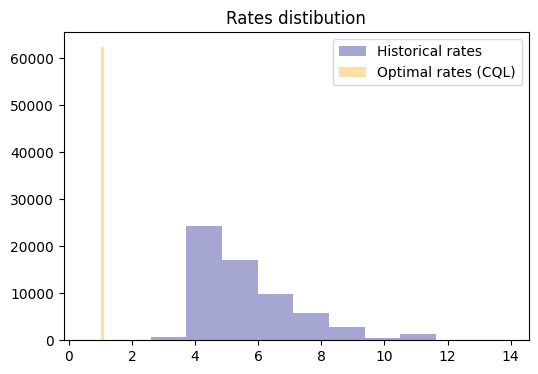

In [66]:
plot_rates_distribution(test_data, best_cql_actions, method='Optimal rates (CQL)')

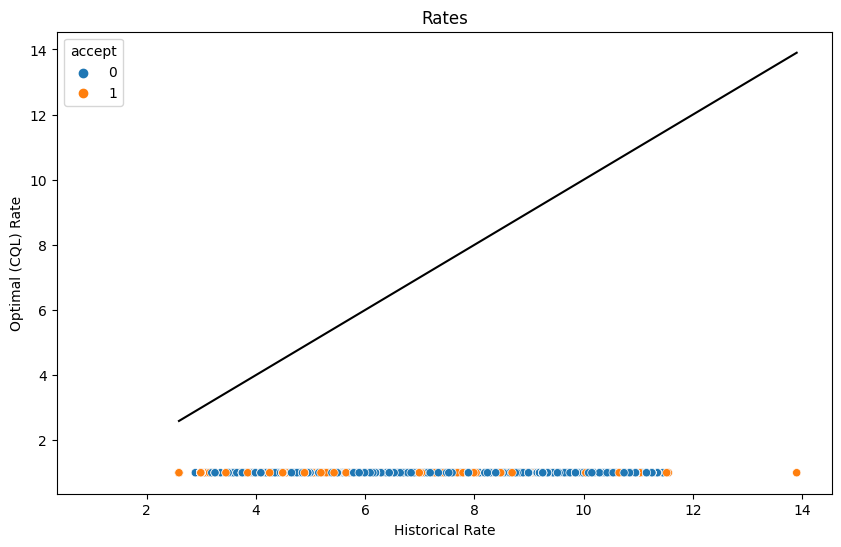

In [67]:
plot_rates(test_data, best_cql_actions, method='Optimal (CQL)')

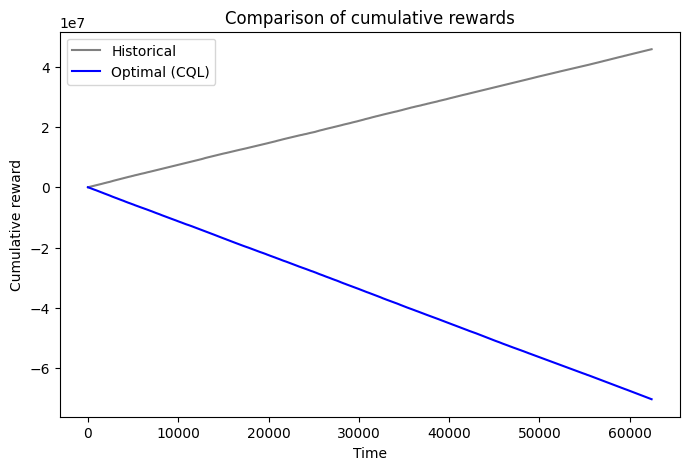

In [68]:
hist_reward_cumulative = np.cumsum(reward(test_data[state_columns], test_data['Rate'], 'logreg'))
opt_reward_cumulative = np.cumsum(reward(test_data[state_columns], best_cql_actions, 'logreg'))
plot_cum_rewards(hist_reward_cumulative, opt_reward_cumulative, method='Optimal (CQL)')